In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import polars as pl
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings

# Suppress warnings globally
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from collections import Counter
import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)

/data/home/novia.permatasari/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_train_test(df, test_size):
    # Make X and Y dataset
    y = df.observation
    print(y.unique())
    X = df.loc[:,'VH_30':'VH_0']
    X['nth'] = df.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)
    return X_train, X_test, y_train, y_test

In [3]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [4]:
kdprov='32'

In [5]:
# Parameters
kdprov = 12


In [6]:
## Read VH dataset
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','rb') as file:
    df=pickle.load(file)
    if isinstance(df, pl.DataFrame):
        df=df.to_pandas()
print(df.shape)
df.head()

(722579, 44)


,idpoint,idsubsegment,idsegment,nth,periode,observation,class,MGRS,VH_30,VH_29,...,VH_4,VH_3,VH_2,VH_1,VH_0,idkabkota,cluster_data,Sigma0VH_variance,winner,prior
0,121223001B1#04,121223001B1,121223001,1,2022_03,3,G,47NME,-14.856341,-13.121625,...,-18.439123,-17.559748,-17.274088,-15.348845,-15.690381,1212,0,0.610976,R19C13,0.426942
1,121223001B2#22,121223001B2,121223001,1,2022_03,3,G,47NME,-15.540250,-14.765509,...,-19.653685,-17.499609,-15.869226,-15.332003,-15.602660,1212,0,0.271942,R13C14,0.523004
2,121223001C2#04,121223001C2,121223001,1,2022_03,6,NV,47NME,-14.738515,-14.240182,...,-17.750420,-15.499076,-14.326104,-14.101879,-14.877516,1212,0,0.570854,R13C15,0.527508
3,121223001C3#08,121223001C3,121223001,1,2022_03,6,NV,47NME,-14.912815,-13.943422,...,-14.655459,-14.402657,-13.954058,-14.101485,-14.168874,1212,0,0.141770,R4C3,0.559560
4,121223001C3#16,121223001C3,121223001,1,2022_03,6,NV,47NME,-14.349282,-13.383128,...,-15.849930,-14.498304,-14.702327,-13.784433,-13.866371,1212,0,0.141770,R7C1,0.599513


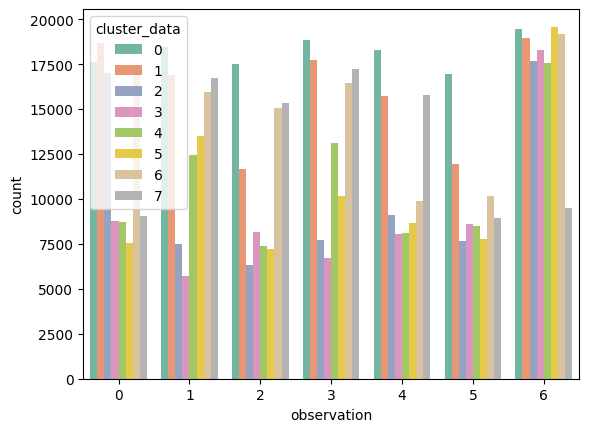

In [7]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))
plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distirbution_plot.png", dpi=300, bbox_inches='tight')


### Running Data

In [8]:
import optuna
from xgboost import XGBClassifier

# Example dataset

# Define the objective function for Bayesian Optimization
def objective(trial,X_train, y_train, n_splits=3):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        #'subsample': trial.suggest_uniform('subsample', 0.5, 0.7),
        #'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.7),
        #'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 0.7),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.1, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 50, 100),
        'objective': 'multi:softprob',  # Multiclass classification
        'eval_metric': ['mlogloss'],
        "tree_method":'hist',
        "num_class": len(set(y_train)),
        "nthread":20
    }
    
    # Define the model
    skf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=42)
    f1_macros=[]
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(param, dtrain_fold, 
                          num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                          verbose_eval=False)
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
    score=np.mean(f1_macros)
    
    return score

In [9]:
def evaluate_model(X_train, y_train, X_test, y_test,cluster, best_params, n_splits=3):
    # Convert data to DMatrix for XGBoost
    class_counts = Counter(y_train)
    total_samples = len(y_train)
        # Step 3: Calculate class weights as inverse of class frequency
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = np.array([class_weights[label] for label in y_train])
        # Create DMatrix with sample weights
        
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True,weight=sample_weights)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    params = best_params
    params['objective']="multi:softprob"
    #params['tree_method']='approx'
    params['eval_metric']='mlogloss'
    params['num_class']=len(set(y_train))
    params['nthread']=20
    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1_macros = []
    f1_micros = []
    aucs = []
    acc_kelas_generatifs = []
    acc_fase_padis = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(params, dtrain_fold, 
                          num_boost_round=10000, evals=evals,early_stopping_rounds=1000,verbose_eval=100)
        
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
        f1_micros.append(f1_score(y_val_fold, y_val_pred, average='micro'))
        aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob, multi_class='ovr'))
        acc_kelas_generatifs.append(akurasi_kelas_generatif(y_val_fold, y_val_pred))
        acc_fase_padis.append(akurasi_fase_padi(y_val_fold, y_val_pred))

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1_macro = sum(f1_macros) / len(f1_macros)
    avg_f1_micro = sum(f1_micros) / len(f1_micros)
    avg_auc = sum(aucs) / len(aucs)
    avg_acc_kelas_generatif = sum(acc_kelas_generatifs) / len(acc_kelas_generatifs)
    avg_acc_fase_padi = sum(acc_fase_padis) / len(acc_fase_padis)
    training_metrics = {
        "average_accuracy": avg_accuracy,
        "average_f1_macro": avg_f1_macro,
        "average_f1_micro": avg_f1_micro,
        "average_auc": avg_auc,
        "average_acc_kelas_generatif": avg_acc_kelas_generatif,
        "average_acc_fase_padi": avg_acc_fase_padi
    }

    
    # Final model evaluation on the test set
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(params, dtrain, 
                      num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                      verbose_eval=50)
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = y_test_pred_prob.argmax(axis=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
    acc_kelas_generatif = akurasi_kelas_generatif(y_test, y_test_pred)
    acc_fase_padi = akurasi_fase_padi(y_test, y_test_pred)
    
    cm = confusion_matrix(y_test, y_test_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    validation_metrics = {
        "val_accuracy": accuracy,
        "val_f1_macro": f1_macro,
        "val_f1_micro": f1_micro,
        "val_auc": auc,
        "val_acc_kelas_generatif": acc_kelas_generatif,
        "val_acc_fase_padi": acc_fase_padi,
        "val_relative_acc": relative_acc
    }

    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred)
    print(report)
    
    # Display Confusion Matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_cm_cluster_{cluster}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, training_metrics, validation_metrics, report, cm

CLUSTER:  0


[3 6 4 1 2 5 0]


[I 2024-10-17 08:41:32,987] A new study created in memory with name: no-name-2559ed48-439b-4fd4-9248-c3a3353c8c91


[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-17 08:42:35,315] Trial 0 finished with value: 0.9384290165893288 and parameters: {'max_depth': 9, 'learning_rate': 0.03893747388424033, 'reg_lambda': 2.8372480178100594, 'min_child_weight': 69}. Best is trial 0 with value: 0.9384290165893288.


[I 2024-10-17 08:44:15,746] Trial 1 finished with value: 0.9370273789707211 and parameters: {'max_depth': 8, 'learning_rate': 0.020894317730423908, 'reg_lambda': 0.7279149022887818, 'min_child_weight': 92}. Best is trial 0 with value: 0.9384290165893288.


[I 2024-10-17 08:44:50,125] Trial 2 finished with value: 0.9383051402376267 and parameters: {'max_depth': 9, 'learning_rate': 0.092597598698149, 'reg_lambda': 3.970248467769863, 'min_child_weight': 97}. Best is trial 0 with value: 0.9384290165893288.


[I 2024-10-17 08:46:31,063] Trial 3 finished with value: 0.9383286435275883 and parameters: {'max_depth': 8, 'learning_rate': 0.026187847491471954, 'reg_lambda': 3.458167897105007, 'min_child_weight': 59}. Best is trial 0 with value: 0.9384290165893288.


[I 2024-10-17 08:47:13,543] Trial 4 finished with value: 0.9382611364419629 and parameters: {'max_depth': 9, 'learning_rate': 0.06578981139035396, 'reg_lambda': 0.18171025663556722, 'min_child_weight': 63}. Best is trial 0 with value: 0.9384290165893288.


[I 2024-10-17 08:47:48,422] Trial 5 finished with value: 0.9378840865969914 and parameters: {'max_depth': 6, 'learning_rate': 0.09462648984318033, 'reg_lambda': 4.82358854001796, 'min_child_weight': 80}. Best is trial 0 with value: 0.9384290165893288.


[I 2024-10-17 08:48:16,251] Trial 6 finished with value: 0.93892985985402 and parameters: {'max_depth': 10, 'learning_rate': 0.08783988258012967, 'reg_lambda': 2.224061799906946, 'min_child_weight': 93}. Best is trial 6 with value: 0.93892985985402.


[I 2024-10-17 08:48:53,841] Trial 7 finished with value: 0.9381981377056666 and parameters: {'max_depth': 7, 'learning_rate': 0.06875347124735048, 'reg_lambda': 4.24493300384913, 'min_child_weight': 80}. Best is trial 6 with value: 0.93892985985402.


[I 2024-10-17 08:49:24,737] Trial 8 finished with value: 0.9385634940526494 and parameters: {'max_depth': 7, 'learning_rate': 0.09905466021342756, 'reg_lambda': 4.204458745779677, 'min_child_weight': 53}. Best is trial 6 with value: 0.93892985985402.


[I 2024-10-17 08:50:49,400] Trial 9 finished with value: 0.9390502922028708 and parameters: {'max_depth': 9, 'learning_rate': 0.03504558022913872, 'reg_lambda': 0.8128077709453962, 'min_child_weight': 67}. Best is trial 9 with value: 0.9390502922028708.


[I 2024-10-17 08:51:51,478] Trial 10 finished with value: 0.9392050652936144 and parameters: {'max_depth': 10, 'learning_rate': 0.04435790428753487, 'reg_lambda': 1.4658454571544037, 'min_child_weight': 72}. Best is trial 10 with value: 0.9392050652936144.


[I 2024-10-17 08:52:55,765] Trial 11 finished with value: 0.9387316297328586 and parameters: {'max_depth': 10, 'learning_rate': 0.043515410281027095, 'reg_lambda': 1.5031551597587545, 'min_child_weight': 73}. Best is trial 10 with value: 0.9392050652936144.


[I 2024-10-17 08:53:41,780] Trial 12 finished with value: 0.9384591557529819 and parameters: {'max_depth': 10, 'learning_rate': 0.0469741669381133, 'reg_lambda': 1.4085577810534797, 'min_child_weight': 67}. Best is trial 10 with value: 0.9392050652936144.


[I 2024-10-17 08:55:39,341] Trial 13 finished with value: 0.9354363530008518 and parameters: {'max_depth': 9, 'learning_rate': 0.012653699449249552, 'reg_lambda': 1.4915076499676454, 'min_child_weight': 83}. Best is trial 10 with value: 0.9392050652936144.


[I 2024-10-17 08:56:26,172] Trial 14 finished with value: 0.9388516508134468 and parameters: {'max_depth': 10, 'learning_rate': 0.05885746348650474, 'reg_lambda': 0.7317176003518178, 'min_child_weight': 51}. Best is trial 10 with value: 0.9392050652936144.


[I 2024-10-17 08:57:47,839] Trial 15 finished with value: 0.9386368765688013 and parameters: {'max_depth': 8, 'learning_rate': 0.03270988900924949, 'reg_lambda': 2.3132747153093245, 'min_child_weight': 73}. Best is trial 10 with value: 0.9392050652936144.


[I 2024-10-17 08:58:38,720] Trial 16 finished with value: 0.938432608889081 and parameters: {'max_depth': 9, 'learning_rate': 0.050511375577362995, 'reg_lambda': 0.8678389975817782, 'min_child_weight': 60}. Best is trial 10 with value: 0.9392050652936144.


[I 2024-10-17 08:59:09,123] Trial 17 finished with value: 0.9387202059123153 and parameters: {'max_depth': 10, 'learning_rate': 0.0745708380474046, 'reg_lambda': 0.1533864778341133, 'min_child_weight': 86}. Best is trial 10 with value: 0.9392050652936144.


[I 2024-10-17 09:00:27,511] Trial 18 finished with value: 0.9387035065481489 and parameters: {'max_depth': 9, 'learning_rate': 0.0327251987337036, 'reg_lambda': 1.6857688366421153, 'min_child_weight': 66}. Best is trial 10 with value: 0.9392050652936144.


[I 2024-10-17 09:02:16,857] Trial 19 finished with value: 0.9324285355751488 and parameters: {'max_depth': 7, 'learning_rate': 0.011716096756730954, 'reg_lambda': 1.9038464908312567, 'min_child_weight': 77}. Best is trial 10 with value: 0.9392050652936144.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.04435790428753487, 'reg_lambda': 1.4658454571544037, 'min_child_weight': 72}
Best Score: 0.9392050652936144
Start the modelling


[0]	train-mlogloss:1.82561	eval-mlogloss:1.82970


[100]	train-mlogloss:0.12631	eval-mlogloss:0.23070


[200]	train-mlogloss:0.05524	eval-mlogloss:0.17570


[300]	train-mlogloss:0.03184	eval-mlogloss:0.16391


[400]	train-mlogloss:0.02207	eval-mlogloss:0.16072


[500]	train-mlogloss:0.01696	eval-mlogloss:0.15957


[600]	train-mlogloss:0.01389	eval-mlogloss:0.15953


[700]	train-mlogloss:0.01187	eval-mlogloss:0.15994


[800]	train-mlogloss:0.01043	eval-mlogloss:0.16047


[900]	train-mlogloss:0.00938	eval-mlogloss:0.16118


[1000]	train-mlogloss:0.00857	eval-mlogloss:0.16197


[1100]	train-mlogloss:0.00791	eval-mlogloss:0.16247


[1200]	train-mlogloss:0.00738	eval-mlogloss:0.16322


[1300]	train-mlogloss:0.00694	eval-mlogloss:0.16396


[1400]	train-mlogloss:0.00658	eval-mlogloss:0.16450


[1500]	train-mlogloss:0.00627	eval-mlogloss:0.16508


[1578]	train-mlogloss:0.00605	eval-mlogloss:0.16558


[0]	train-mlogloss:1.82489	eval-mlogloss:1.82904


[100]	train-mlogloss:0.12416	eval-mlogloss:0.23288


[200]	train-mlogloss:0.05232	eval-mlogloss:0.17888


[300]	train-mlogloss:0.03126	eval-mlogloss:0.16864


[400]	train-mlogloss:0.02169	eval-mlogloss:0.16599


[500]	train-mlogloss:0.01671	eval-mlogloss:0.16537


[600]	train-mlogloss:0.01371	eval-mlogloss:0.16595


[700]	train-mlogloss:0.01174	eval-mlogloss:0.16694


[800]	train-mlogloss:0.01034	eval-mlogloss:0.16768


[900]	train-mlogloss:0.00929	eval-mlogloss:0.16834


[1000]	train-mlogloss:0.00849	eval-mlogloss:0.16915


[1100]	train-mlogloss:0.00784	eval-mlogloss:0.16968


[1200]	train-mlogloss:0.00732	eval-mlogloss:0.17029


[1300]	train-mlogloss:0.00688	eval-mlogloss:0.17110


[1400]	train-mlogloss:0.00651	eval-mlogloss:0.17171


[1491]	train-mlogloss:0.00623	eval-mlogloss:0.17229


[0]	train-mlogloss:1.82491	eval-mlogloss:1.83025


[100]	train-mlogloss:0.12230	eval-mlogloss:0.24134


[200]	train-mlogloss:0.05157	eval-mlogloss:0.18956


[300]	train-mlogloss:0.02993	eval-mlogloss:0.17957


[400]	train-mlogloss:0.02091	eval-mlogloss:0.17778


[500]	train-mlogloss:0.01613	eval-mlogloss:0.17799


[600]	train-mlogloss:0.01329	eval-mlogloss:0.17920


[700]	train-mlogloss:0.01140	eval-mlogloss:0.18042


[800]	train-mlogloss:0.01008	eval-mlogloss:0.18195


[900]	train-mlogloss:0.00909	eval-mlogloss:0.18335


[1000]	train-mlogloss:0.00833	eval-mlogloss:0.18461


[1100]	train-mlogloss:0.00772	eval-mlogloss:0.18587


[1200]	train-mlogloss:0.00722	eval-mlogloss:0.18710


[1300]	train-mlogloss:0.00680	eval-mlogloss:0.18819


[1400]	train-mlogloss:0.00646	eval-mlogloss:0.18932


[1416]	train-mlogloss:0.00640	eval-mlogloss:0.18949


[0]	train-mlogloss:1.82387	eval-mlogloss:1.82760


[50]	train-mlogloss:0.30945	eval-mlogloss:0.38533


[100]	train-mlogloss:0.12400	eval-mlogloss:0.22098


[150]	train-mlogloss:0.07591	eval-mlogloss:0.18231


[200]	train-mlogloss:0.05476	eval-mlogloss:0.16720


[250]	train-mlogloss:0.04184	eval-mlogloss:0.16003


[300]	train-mlogloss:0.03289	eval-mlogloss:0.15577


[350]	train-mlogloss:0.02675	eval-mlogloss:0.15335


[400]	train-mlogloss:0.02235	eval-mlogloss:0.15177


[450]	train-mlogloss:0.01924	eval-mlogloss:0.15101


[500]	train-mlogloss:0.01688	eval-mlogloss:0.15068


[550]	train-mlogloss:0.01498	eval-mlogloss:0.15060


[600]	train-mlogloss:0.01353	eval-mlogloss:0.15080


[606]	train-mlogloss:0.01337	eval-mlogloss:0.15082



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12341
           1       0.93      0.91      0.92     12923
           2       0.92      0.93      0.93     12263
           3       0.95      0.93      0.94     13197
           4       0.94      0.95      0.95     12815
           5       0.93      0.94      0.94     11859
           6       0.98      0.98      0.98     13624

    accuracy                           0.94     89022
   macro avg       0.94      0.94      0.94     89022
weighted avg       0.94      0.94      0.94     89022



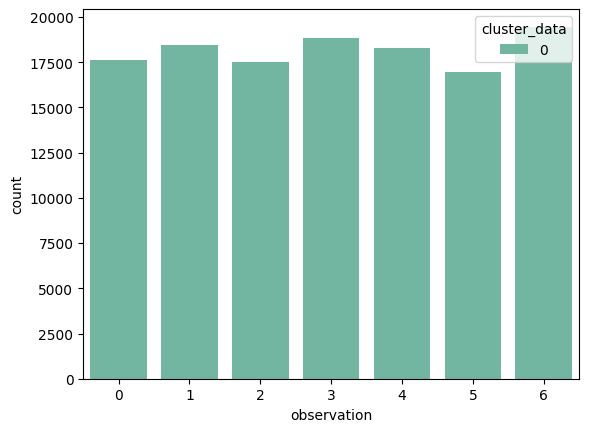

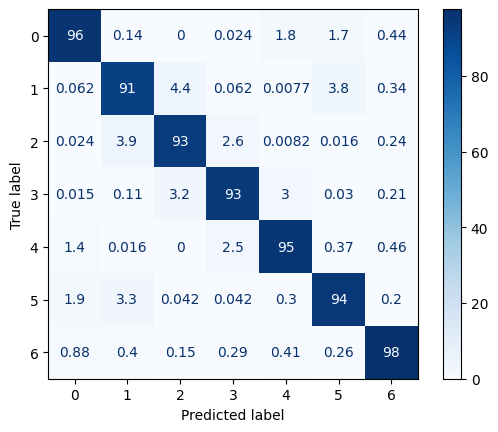

{'average_accuracy': 0.9408418082458597, 'average_f1_macro': np.float64(0.9404044372837195), 'average_f1_micro': np.float64(0.9408418082458597), 'average_auc': np.float64(0.997131905776968), 'average_acc_kelas_generatif': 0.935113400147956, 'average_acc_fase_padi': 0.929043224811974}
{'val_accuracy': 0.9445979645480892, 'val_f1_macro': np.float64(0.9442262830284458), 'val_f1_micro': np.float64(0.9445979645480892), 'val_auc': np.float64(0.9976348745601195), 'val_acc_kelas_generatif': 0.9343032507388043, 'val_acc_fase_padi': 0.9332981757099886, 'val_relative_acc': np.float64(99.93275158113842)}
CLUSTER:  1


[I 2024-10-17 09:04:56,024] A new study created in memory with name: no-name-823031a6-5d53-4554-be97-441f56443e2b


[6 2 0 5 1 4 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-17 09:06:09,616] Trial 0 finished with value: 0.9396533008391188 and parameters: {'max_depth': 6, 'learning_rate': 0.04171213852216778, 'reg_lambda': 4.045343594355378, 'min_child_weight': 57}. Best is trial 0 with value: 0.9396533008391188.


[I 2024-10-17 09:07:31,505] Trial 1 finished with value: 0.9339755776183578 and parameters: {'max_depth': 6, 'learning_rate': 0.016827998462749114, 'reg_lambda': 1.2101577260977063, 'min_child_weight': 53}. Best is trial 0 with value: 0.9396533008391188.


[I 2024-10-17 09:08:12,548] Trial 2 finished with value: 0.9390468388073742 and parameters: {'max_depth': 9, 'learning_rate': 0.09092542401516648, 'reg_lambda': 1.1918722597894742, 'min_child_weight': 80}. Best is trial 0 with value: 0.9396533008391188.


[I 2024-10-17 09:09:03,165] Trial 3 finished with value: 0.9382656042494871 and parameters: {'max_depth': 9, 'learning_rate': 0.057567774948246914, 'reg_lambda': 4.973547943135471, 'min_child_weight': 91}. Best is trial 0 with value: 0.9396533008391188.


[I 2024-10-17 09:10:07,282] Trial 4 finished with value: 0.9373413821792641 and parameters: {'max_depth': 6, 'learning_rate': 0.03556099801699158, 'reg_lambda': 4.5093099538771755, 'min_child_weight': 99}. Best is trial 0 with value: 0.9396533008391188.


[I 2024-10-17 09:10:42,902] Trial 5 finished with value: 0.9398918119861324 and parameters: {'max_depth': 6, 'learning_rate': 0.08013082381646511, 'reg_lambda': 0.5713979912330037, 'min_child_weight': 56}. Best is trial 5 with value: 0.9398918119861324.


[I 2024-10-17 09:11:14,579] Trial 6 finished with value: 0.938447736180731 and parameters: {'max_depth': 7, 'learning_rate': 0.0920209561942356, 'reg_lambda': 1.1211718766776884, 'min_child_weight': 72}. Best is trial 5 with value: 0.9398918119861324.


[I 2024-10-17 09:12:04,270] Trial 7 finished with value: 0.9385189512285114 and parameters: {'max_depth': 7, 'learning_rate': 0.05874642534784781, 'reg_lambda': 2.2399906211820486, 'min_child_weight': 75}. Best is trial 5 with value: 0.9398918119861324.


[I 2024-10-17 09:12:42,574] Trial 8 finished with value: 0.938522629830735 and parameters: {'max_depth': 9, 'learning_rate': 0.07245353723752258, 'reg_lambda': 0.9602532073313508, 'min_child_weight': 77}. Best is trial 5 with value: 0.9398918119861324.


[I 2024-10-17 09:13:37,347] Trial 9 finished with value: 0.9387503979874045 and parameters: {'max_depth': 10, 'learning_rate': 0.05233866413242948, 'reg_lambda': 3.9218994151484896, 'min_child_weight': 84}. Best is trial 5 with value: 0.9398918119861324.


[I 2024-10-17 09:14:16,772] Trial 10 finished with value: 0.9396160401298701 and parameters: {'max_depth': 7, 'learning_rate': 0.07559662609932913, 'reg_lambda': 0.21726427408934357, 'min_child_weight': 63}. Best is trial 5 with value: 0.9398918119861324.


[I 2024-10-17 09:15:13,690] Trial 11 finished with value: 0.9393666394025587 and parameters: {'max_depth': 6, 'learning_rate': 0.039259985983145854, 'reg_lambda': 3.1400572945440706, 'min_child_weight': 51}. Best is trial 5 with value: 0.9398918119861324.


[I 2024-10-17 09:17:06,159] Trial 12 finished with value: 0.9319814199000193 and parameters: {'max_depth': 8, 'learning_rate': 0.0104826956242325, 'reg_lambda': 2.7534963860283588, 'min_child_weight': 61}. Best is trial 5 with value: 0.9398918119861324.


[I 2024-10-17 09:18:22,411] Trial 13 finished with value: 0.93924078095994 and parameters: {'max_depth': 6, 'learning_rate': 0.03558022966386939, 'reg_lambda': 3.887719525055504, 'min_child_weight': 62}. Best is trial 5 with value: 0.9398918119861324.


[I 2024-10-17 09:19:02,765] Trial 14 finished with value: 0.9393819408868542 and parameters: {'max_depth': 7, 'learning_rate': 0.07469621505517582, 'reg_lambda': 1.9626192455452292, 'min_child_weight': 68}. Best is trial 5 with value: 0.9398918119861324.


[I 2024-10-17 09:19:56,901] Trial 15 finished with value: 0.9391295698315236 and parameters: {'max_depth': 8, 'learning_rate': 0.04674168224193197, 'reg_lambda': 0.16705321839304343, 'min_child_weight': 56}. Best is trial 5 with value: 0.9398918119861324.


[I 2024-10-17 09:21:05,637] Trial 16 finished with value: 0.9374157132345297 and parameters: {'max_depth': 6, 'learning_rate': 0.02524383315766921, 'reg_lambda': 3.399683508301747, 'min_child_weight': 57}. Best is trial 5 with value: 0.9398918119861324.


[I 2024-10-17 09:21:51,665] Trial 17 finished with value: 0.939796413972438 and parameters: {'max_depth': 7, 'learning_rate': 0.06407138989949857, 'reg_lambda': 2.0370841181332757, 'min_child_weight': 68}. Best is trial 5 with value: 0.9398918119861324.


[I 2024-10-17 09:22:20,450] Trial 18 finished with value: 0.9382064286468955 and parameters: {'max_depth': 7, 'learning_rate': 0.09958560470932537, 'reg_lambda': 1.913021920999629, 'min_child_weight': 68}. Best is trial 5 with value: 0.9398918119861324.


[I 2024-10-17 09:23:12,892] Trial 19 finished with value: 0.9385710173530214 and parameters: {'max_depth': 8, 'learning_rate': 0.06558750867551459, 'reg_lambda': 0.6461049464752558, 'min_child_weight': 67}. Best is trial 5 with value: 0.9398918119861324.


Best Parameters: {'max_depth': 6, 'learning_rate': 0.08013082381646511, 'reg_lambda': 0.5713979912330037, 'min_child_weight': 56}
Best Score: 0.9398918119861324
Start the modelling


[0]	train-mlogloss:1.74520	eval-mlogloss:1.75144


[100]	train-mlogloss:0.11337	eval-mlogloss:0.20944


[200]	train-mlogloss:0.05361	eval-mlogloss:0.17470


[300]	train-mlogloss:0.03071	eval-mlogloss:0.16623


[400]	train-mlogloss:0.01969	eval-mlogloss:0.16440


[500]	train-mlogloss:0.01392	eval-mlogloss:0.16453


[600]	train-mlogloss:0.01070	eval-mlogloss:0.16539


[700]	train-mlogloss:0.00870	eval-mlogloss:0.16648


[800]	train-mlogloss:0.00733	eval-mlogloss:0.16808


[900]	train-mlogloss:0.00638	eval-mlogloss:0.16964


[1000]	train-mlogloss:0.00570	eval-mlogloss:0.17100


[1100]	train-mlogloss:0.00518	eval-mlogloss:0.17232


[1200]	train-mlogloss:0.00479	eval-mlogloss:0.17336


[1300]	train-mlogloss:0.00447	eval-mlogloss:0.17450


[1400]	train-mlogloss:0.00422	eval-mlogloss:0.17529


[1411]	train-mlogloss:0.00419	eval-mlogloss:0.17545


[0]	train-mlogloss:1.74592	eval-mlogloss:1.75006


[100]	train-mlogloss:0.11382	eval-mlogloss:0.19920


[200]	train-mlogloss:0.05464	eval-mlogloss:0.16600


[300]	train-mlogloss:0.03073	eval-mlogloss:0.15706


[400]	train-mlogloss:0.01968	eval-mlogloss:0.15519


[500]	train-mlogloss:0.01411	eval-mlogloss:0.15556


[600]	train-mlogloss:0.01086	eval-mlogloss:0.15676


[700]	train-mlogloss:0.00879	eval-mlogloss:0.15809


[800]	train-mlogloss:0.00743	eval-mlogloss:0.15964


[900]	train-mlogloss:0.00646	eval-mlogloss:0.16124


[1000]	train-mlogloss:0.00575	eval-mlogloss:0.16284


[1100]	train-mlogloss:0.00522	eval-mlogloss:0.16368


[1200]	train-mlogloss:0.00482	eval-mlogloss:0.16477


[1300]	train-mlogloss:0.00449	eval-mlogloss:0.16549


[1400]	train-mlogloss:0.00423	eval-mlogloss:0.16628


[1432]	train-mlogloss:0.00415	eval-mlogloss:0.16641


[0]	train-mlogloss:1.74501	eval-mlogloss:1.75305


[100]	train-mlogloss:0.11317	eval-mlogloss:0.20625


[200]	train-mlogloss:0.05286	eval-mlogloss:0.17075


[300]	train-mlogloss:0.02999	eval-mlogloss:0.16212


[400]	train-mlogloss:0.01951	eval-mlogloss:0.16063


[500]	train-mlogloss:0.01395	eval-mlogloss:0.16098


[600]	train-mlogloss:0.01088	eval-mlogloss:0.16240


[700]	train-mlogloss:0.00882	eval-mlogloss:0.16362


[800]	train-mlogloss:0.00745	eval-mlogloss:0.16545


[900]	train-mlogloss:0.00647	eval-mlogloss:0.16695


[1000]	train-mlogloss:0.00575	eval-mlogloss:0.16836


[1100]	train-mlogloss:0.00522	eval-mlogloss:0.16985


[1200]	train-mlogloss:0.00481	eval-mlogloss:0.17063


[1300]	train-mlogloss:0.00450	eval-mlogloss:0.17160


[1400]	train-mlogloss:0.00423	eval-mlogloss:0.17249


[1450]	train-mlogloss:0.00412	eval-mlogloss:0.17288


[0]	train-mlogloss:1.74618	eval-mlogloss:1.75108


[50]	train-mlogloss:0.21613	eval-mlogloss:0.27071


[100]	train-mlogloss:0.12111	eval-mlogloss:0.18873


[150]	train-mlogloss:0.08639	eval-mlogloss:0.16499


[200]	train-mlogloss:0.06328	eval-mlogloss:0.15207


[250]	train-mlogloss:0.04863	eval-mlogloss:0.14508


[300]	train-mlogloss:0.03807	eval-mlogloss:0.14043


[350]	train-mlogloss:0.03010	eval-mlogloss:0.13761


[400]	train-mlogloss:0.02418	eval-mlogloss:0.13542


[450]	train-mlogloss:0.02016	eval-mlogloss:0.13434


[500]	train-mlogloss:0.01705	eval-mlogloss:0.13385


[547]	train-mlogloss:0.01489	eval-mlogloss:0.13387



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     13073
           1       0.95      0.94      0.95     11843
           2       0.94      0.95      0.95      8168
           3       0.95      0.95      0.95     12427
           4       0.94      0.95      0.94     11016
           5       0.91      0.93      0.92      8369
           6       0.99      0.99      0.99     13279

    accuracy                           0.95     78175
   macro avg       0.95      0.95      0.95     78175
weighted avg       0.95      0.95      0.95     78175



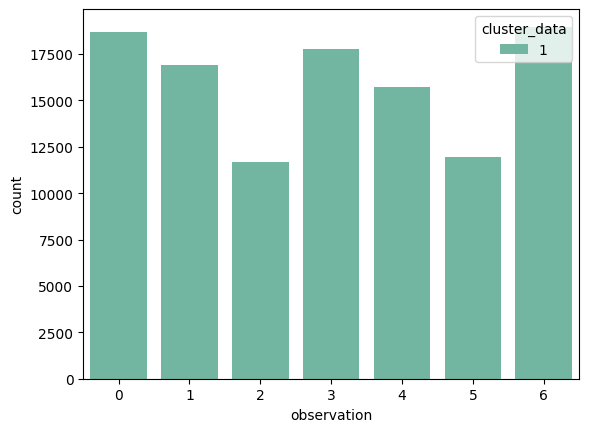

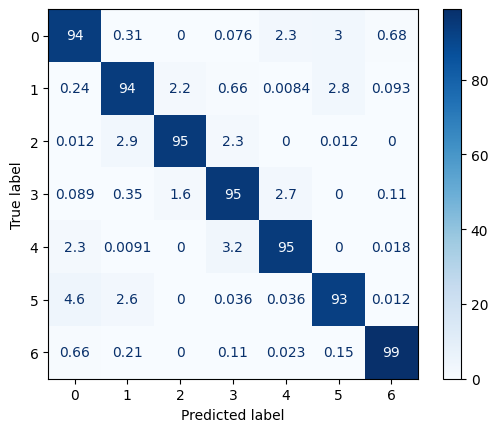

{'average_accuracy': 0.9435871841143347, 'average_f1_macro': np.float64(0.9412785760513372), 'average_f1_micro': np.float64(0.9435871841143347), 'average_auc': np.float64(0.9972886158314433), 'average_acc_kelas_generatif': 0.9463004906314766, 'average_acc_fase_padi': 0.9404498741721049}
{'val_accuracy': 0.9494851295171091, 'val_f1_macro': np.float64(0.9474898556768164), 'val_f1_micro': np.float64(0.9494851295171091), 'val_auc': np.float64(0.9980072590638548), 'val_acc_kelas_generatif': 0.9512352136477026, 'val_acc_fase_padi': 0.9459428361025453, 'val_relative_acc': np.float64(99.74958427076201)}
CLUSTER:  2


[I 2024-10-17 09:25:16,551] A new study created in memory with name: no-name-6a2236ed-687f-4d35-b1b6-8ccaae58dfb7


[6 4 3 0 2 1 5]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-17 09:25:43,736] Trial 0 finished with value: 0.8388674390415022 and parameters: {'max_depth': 10, 'learning_rate': 0.051095862135958764, 'reg_lambda': 1.5760272492767908, 'min_child_weight': 55}. Best is trial 0 with value: 0.8388674390415022.


[I 2024-10-17 09:26:06,638] Trial 1 finished with value: 0.8390717585041033 and parameters: {'max_depth': 6, 'learning_rate': 0.0897854252282301, 'reg_lambda': 3.680655686159189, 'min_child_weight': 74}. Best is trial 1 with value: 0.8390717585041033.


[I 2024-10-17 09:26:44,892] Trial 2 finished with value: 0.8411772879701255 and parameters: {'max_depth': 7, 'learning_rate': 0.05096051928851941, 'reg_lambda': 0.11978988411614405, 'min_child_weight': 51}. Best is trial 2 with value: 0.8411772879701255.


[I 2024-10-17 09:27:34,362] Trial 3 finished with value: 0.8415402222138487 and parameters: {'max_depth': 10, 'learning_rate': 0.04418382934501583, 'reg_lambda': 0.4516329890232449, 'min_child_weight': 62}. Best is trial 3 with value: 0.8415402222138487.


[I 2024-10-17 09:29:03,004] Trial 4 finished with value: 0.8355503360317004 and parameters: {'max_depth': 8, 'learning_rate': 0.01306177942205284, 'reg_lambda': 0.5434935690914616, 'min_child_weight': 99}. Best is trial 3 with value: 0.8415402222138487.


[I 2024-10-17 09:29:30,527] Trial 5 finished with value: 0.8373373952872468 and parameters: {'max_depth': 8, 'learning_rate': 0.08542786166045689, 'reg_lambda': 0.33591513996355626, 'min_child_weight': 97}. Best is trial 3 with value: 0.8415402222138487.


[I 2024-10-17 09:30:40,364] Trial 6 finished with value: 0.8396628360831729 and parameters: {'max_depth': 10, 'learning_rate': 0.02908674030147578, 'reg_lambda': 2.8486871415551227, 'min_child_weight': 56}. Best is trial 3 with value: 0.8415402222138487.


[I 2024-10-17 09:31:07,964] Trial 7 finished with value: 0.8398320376948701 and parameters: {'max_depth': 9, 'learning_rate': 0.05750528656878257, 'reg_lambda': 1.4379274837826814, 'min_child_weight': 57}. Best is trial 3 with value: 0.8415402222138487.


[I 2024-10-17 09:31:51,760] Trial 8 finished with value: 0.8381808491203833 and parameters: {'max_depth': 6, 'learning_rate': 0.04249110641683284, 'reg_lambda': 0.4976658567988774, 'min_child_weight': 93}. Best is trial 3 with value: 0.8415402222138487.


[I 2024-10-17 09:32:22,475] Trial 9 finished with value: 0.8395040518455593 and parameters: {'max_depth': 6, 'learning_rate': 0.07952028427764883, 'reg_lambda': 3.475036783127443, 'min_child_weight': 77}. Best is trial 3 with value: 0.8415402222138487.


[I 2024-10-17 09:32:53,492] Trial 10 finished with value: 0.8411347471256166 and parameters: {'max_depth': 9, 'learning_rate': 0.06803729599296769, 'reg_lambda': 4.9747604061808115, 'min_child_weight': 71}. Best is trial 3 with value: 0.8415402222138487.


[I 2024-10-17 09:33:52,457] Trial 11 finished with value: 0.8400585525924952 and parameters: {'max_depth': 7, 'learning_rate': 0.032813648995175304, 'reg_lambda': 1.4633837131340963, 'min_child_weight': 50}. Best is trial 3 with value: 0.8415402222138487.


[I 2024-10-17 09:34:26,935] Trial 12 finished with value: 0.8415863904834855 and parameters: {'max_depth': 7, 'learning_rate': 0.06427601195028218, 'reg_lambda': 0.12649310339975658, 'min_child_weight': 64}. Best is trial 12 with value: 0.8415863904834855.


[I 2024-10-17 09:34:59,785] Trial 13 finished with value: 0.8421031154443042 and parameters: {'max_depth': 7, 'learning_rate': 0.06555306741160075, 'reg_lambda': 1.1423386558456634, 'min_child_weight': 67}. Best is trial 13 with value: 0.8421031154443042.


[I 2024-10-17 09:35:30,697] Trial 14 finished with value: 0.8388944053337942 and parameters: {'max_depth': 7, 'learning_rate': 0.06909581985067285, 'reg_lambda': 1.9069563788527373, 'min_child_weight': 67}. Best is trial 13 with value: 0.8421031154443042.


[I 2024-10-17 09:35:58,936] Trial 15 finished with value: 0.8380683711421413 and parameters: {'max_depth': 7, 'learning_rate': 0.06961725458908699, 'reg_lambda': 1.0947730725360778, 'min_child_weight': 84}. Best is trial 13 with value: 0.8421031154443042.


[I 2024-10-17 09:36:15,574] Trial 16 finished with value: 0.8399001582194233 and parameters: {'max_depth': 8, 'learning_rate': 0.09664073190525493, 'reg_lambda': 2.3552269033460087, 'min_child_weight': 65}. Best is trial 13 with value: 0.8421031154443042.


[I 2024-10-17 09:36:42,719] Trial 17 finished with value: 0.8400833843233438 and parameters: {'max_depth': 7, 'learning_rate': 0.061373956038849875, 'reg_lambda': 0.9165011919800778, 'min_child_weight': 81}. Best is trial 13 with value: 0.8421031154443042.


[I 2024-10-17 09:37:09,538] Trial 18 finished with value: 0.841101201536769 and parameters: {'max_depth': 9, 'learning_rate': 0.07950620919659399, 'reg_lambda': 0.9071731796860671, 'min_child_weight': 63}. Best is trial 13 with value: 0.8421031154443042.


[I 2024-10-17 09:37:40,291] Trial 19 finished with value: 0.8387331928965059 and parameters: {'max_depth': 6, 'learning_rate': 0.0746124414613315, 'reg_lambda': 2.17164788359965, 'min_child_weight': 70}. Best is trial 13 with value: 0.8421031154443042.


Best Parameters: {'max_depth': 7, 'learning_rate': 0.06555306741160075, 'reg_lambda': 1.1423386558456634, 'min_child_weight': 67}
Best Score: 0.8421031154443042
Start the modelling


[0]	train-mlogloss:1.80421	eval-mlogloss:1.81416


[100]	train-mlogloss:0.27499	eval-mlogloss:0.48693


[200]	train-mlogloss:0.16735	eval-mlogloss:0.44990


[300]	train-mlogloss:0.10904	eval-mlogloss:0.43966


[400]	train-mlogloss:0.07685	eval-mlogloss:0.44014


[500]	train-mlogloss:0.05712	eval-mlogloss:0.44414


[600]	train-mlogloss:0.04422	eval-mlogloss:0.45037


[700]	train-mlogloss:0.03558	eval-mlogloss:0.45747


[800]	train-mlogloss:0.02955	eval-mlogloss:0.46463


[900]	train-mlogloss:0.02509	eval-mlogloss:0.47121


[1000]	train-mlogloss:0.02180	eval-mlogloss:0.47709


[1100]	train-mlogloss:0.01925	eval-mlogloss:0.48265


[1200]	train-mlogloss:0.01725	eval-mlogloss:0.48794


[1300]	train-mlogloss:0.01567	eval-mlogloss:0.49311


[1330]	train-mlogloss:0.01523	eval-mlogloss:0.49459


[0]	train-mlogloss:1.80435	eval-mlogloss:1.81326


[100]	train-mlogloss:0.28397	eval-mlogloss:0.47937


[200]	train-mlogloss:0.16837	eval-mlogloss:0.43918


[300]	train-mlogloss:0.11110	eval-mlogloss:0.42954


[400]	train-mlogloss:0.07640	eval-mlogloss:0.42732


[500]	train-mlogloss:0.05584	eval-mlogloss:0.42997


[600]	train-mlogloss:0.04278	eval-mlogloss:0.43441


[700]	train-mlogloss:0.03467	eval-mlogloss:0.44045


[800]	train-mlogloss:0.02893	eval-mlogloss:0.44632


[900]	train-mlogloss:0.02468	eval-mlogloss:0.45237


[1000]	train-mlogloss:0.02142	eval-mlogloss:0.45833


[1100]	train-mlogloss:0.01888	eval-mlogloss:0.46424


[1200]	train-mlogloss:0.01690	eval-mlogloss:0.46942


[1300]	train-mlogloss:0.01533	eval-mlogloss:0.47495


[1400]	train-mlogloss:0.01406	eval-mlogloss:0.47951


[1402]	train-mlogloss:0.01404	eval-mlogloss:0.47957


[0]	train-mlogloss:1.80497	eval-mlogloss:1.81333


[100]	train-mlogloss:0.27890	eval-mlogloss:0.48986


[200]	train-mlogloss:0.16858	eval-mlogloss:0.45661


[300]	train-mlogloss:0.11079	eval-mlogloss:0.44749


[400]	train-mlogloss:0.07627	eval-mlogloss:0.44655


[500]	train-mlogloss:0.05665	eval-mlogloss:0.44871


[600]	train-mlogloss:0.04346	eval-mlogloss:0.45444


[700]	train-mlogloss:0.03510	eval-mlogloss:0.46110


[800]	train-mlogloss:0.02900	eval-mlogloss:0.46892


[900]	train-mlogloss:0.02473	eval-mlogloss:0.47563


[1000]	train-mlogloss:0.02141	eval-mlogloss:0.48193


[1100]	train-mlogloss:0.01905	eval-mlogloss:0.48741


[1200]	train-mlogloss:0.01708	eval-mlogloss:0.49299


[1300]	train-mlogloss:0.01549	eval-mlogloss:0.49800


[1352]	train-mlogloss:0.01479	eval-mlogloss:0.50058


[0]	train-mlogloss:1.80400	eval-mlogloss:1.81251


[50]	train-mlogloss:0.43540	eval-mlogloss:0.56947


[100]	train-mlogloss:0.29976	eval-mlogloss:0.47870


[150]	train-mlogloss:0.24185	eval-mlogloss:0.45367


[200]	train-mlogloss:0.19757	eval-mlogloss:0.43972


[250]	train-mlogloss:0.16262	eval-mlogloss:0.43134


[300]	train-mlogloss:0.13750	eval-mlogloss:0.42731


[350]	train-mlogloss:0.11652	eval-mlogloss:0.42482


[400]	train-mlogloss:0.10016	eval-mlogloss:0.42404


[450]	train-mlogloss:0.08603	eval-mlogloss:0.42388


[500]	train-mlogloss:0.07435	eval-mlogloss:0.42455


[516]	train-mlogloss:0.07127	eval-mlogloss:0.42484



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     11921
           1       0.91      0.94      0.92      5262
           2       0.93      0.93      0.93      4409
           3       0.91      0.88      0.90      5403
           4       0.75      0.69      0.72      6360
           5       0.73      0.67      0.70      5362
           6       0.82      0.90      0.85     12353

    accuracy                           0.85     51070
   macro avg       0.85      0.84      0.85     51070
weighted avg       0.85      0.85      0.85     51070



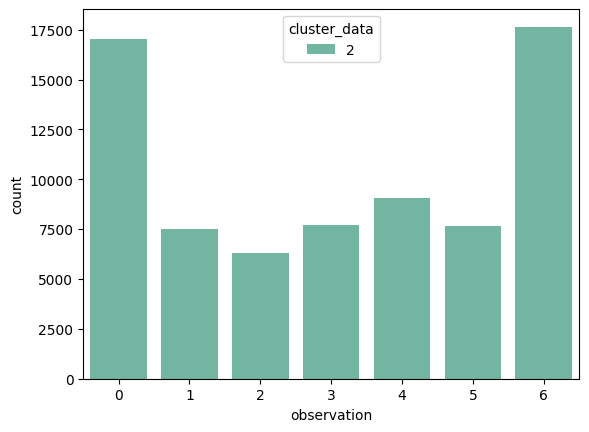

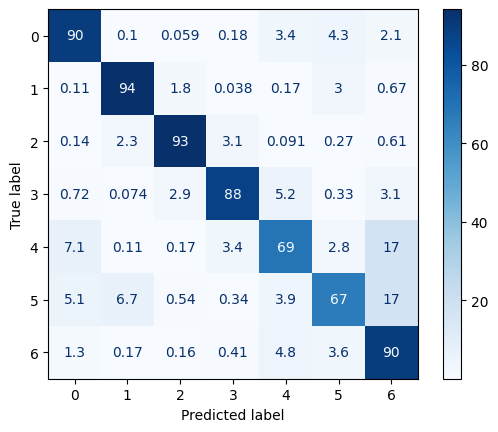

{'average_accuracy': 0.8492711226747471, 'average_f1_macro': np.float64(0.8407481111553986), 'average_f1_micro': np.float64(0.8492711226747471), 'average_auc': np.float64(0.9752830437345076), 'average_acc_kelas_generatif': 0.8544905008635578, 'average_acc_fase_padi': 0.8357282821685174}
{'val_accuracy': 0.8532014881535148, 'val_f1_macro': np.float64(0.8472555354856013), 'val_f1_micro': np.float64(0.8532014881535148), 'val_auc': np.float64(0.9767192042176965), 'val_acc_kelas_generatif': 0.8772903942254303, 'val_acc_fase_padi': 0.8508444527386395, 'val_relative_acc': np.float64(99.5210285282131)}
CLUSTER:  3


[I 2024-10-17 09:39:44,231] A new study created in memory with name: no-name-aa1ede84-e8fc-4f73-be66-45b8b7ba0767


[5 6 2 3 1 4 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-17 09:40:19,193] Trial 0 finished with value: 0.6767143657630145 and parameters: {'max_depth': 9, 'learning_rate': 0.06323813876779932, 'reg_lambda': 1.7017120421728822, 'min_child_weight': 66}. Best is trial 0 with value: 0.6767143657630145.


[I 2024-10-17 09:40:42,940] Trial 1 finished with value: 0.6745925016683877 and parameters: {'max_depth': 9, 'learning_rate': 0.09763947797369288, 'reg_lambda': 1.1574631450636368, 'min_child_weight': 70}. Best is trial 0 with value: 0.6767143657630145.


[I 2024-10-17 09:41:11,495] Trial 2 finished with value: 0.6771905905773332 and parameters: {'max_depth': 9, 'learning_rate': 0.08247199961769401, 'reg_lambda': 4.966154079260148, 'min_child_weight': 85}. Best is trial 2 with value: 0.6771905905773332.


[I 2024-10-17 09:41:34,159] Trial 3 finished with value: 0.6744224033807179 and parameters: {'max_depth': 6, 'learning_rate': 0.07868397386188665, 'reg_lambda': 4.400843415271553, 'min_child_weight': 65}. Best is trial 2 with value: 0.6771905905773332.


[I 2024-10-17 09:42:18,171] Trial 4 finished with value: 0.6748763316306797 and parameters: {'max_depth': 6, 'learning_rate': 0.05326092132897758, 'reg_lambda': 0.9898245292460482, 'min_child_weight': 54}. Best is trial 2 with value: 0.6771905905773332.


[I 2024-10-17 09:43:18,765] Trial 5 finished with value: 0.6742293043300945 and parameters: {'max_depth': 7, 'learning_rate': 0.03600314743188159, 'reg_lambda': 3.809317046295907, 'min_child_weight': 87}. Best is trial 2 with value: 0.6771905905773332.


[I 2024-10-17 09:43:45,658] Trial 6 finished with value: 0.676278804883065 and parameters: {'max_depth': 9, 'learning_rate': 0.09375206093332793, 'reg_lambda': 2.010475835122052, 'min_child_weight': 91}. Best is trial 2 with value: 0.6771905905773332.


[I 2024-10-17 09:44:34,567] Trial 7 finished with value: 0.6790225261755846 and parameters: {'max_depth': 9, 'learning_rate': 0.044056683164374826, 'reg_lambda': 2.5031147143865846, 'min_child_weight': 53}. Best is trial 7 with value: 0.6790225261755846.


[I 2024-10-17 09:45:14,931] Trial 8 finished with value: 0.6758658040698947 and parameters: {'max_depth': 6, 'learning_rate': 0.05587579687065582, 'reg_lambda': 3.935961643235747, 'min_child_weight': 65}. Best is trial 7 with value: 0.6790225261755846.


[I 2024-10-17 09:46:59,980] Trial 9 finished with value: 0.6718067945734449 and parameters: {'max_depth': 10, 'learning_rate': 0.011385992127314674, 'reg_lambda': 1.357039293227048, 'min_child_weight': 90}. Best is trial 7 with value: 0.6790225261755846.


[I 2024-10-17 09:48:13,258] Trial 10 finished with value: 0.6770774666020484 and parameters: {'max_depth': 8, 'learning_rate': 0.02795053265604196, 'reg_lambda': 2.938568811150679, 'min_child_weight': 50}. Best is trial 7 with value: 0.6790225261755846.


[I 2024-10-17 09:48:50,749] Trial 11 finished with value: 0.6777216524816451 and parameters: {'max_depth': 10, 'learning_rate': 0.07495623976914788, 'reg_lambda': 2.8672584233400973, 'min_child_weight': 81}. Best is trial 7 with value: 0.6790225261755846.


[I 2024-10-17 09:49:46,724] Trial 12 finished with value: 0.6781574422378758 and parameters: {'max_depth': 10, 'learning_rate': 0.040337991194926995, 'reg_lambda': 2.6332799777542086, 'min_child_weight': 100}. Best is trial 7 with value: 0.6790225261755846.


[I 2024-10-17 09:50:42,410] Trial 13 finished with value: 0.6744366158712475 and parameters: {'max_depth': 10, 'learning_rate': 0.03913379726574804, 'reg_lambda': 2.393588115364673, 'min_child_weight': 96}. Best is trial 7 with value: 0.6790225261755846.


[I 2024-10-17 09:52:00,594] Trial 14 finished with value: 0.6737658240444797 and parameters: {'max_depth': 8, 'learning_rate': 0.020369226664529602, 'reg_lambda': 0.1662053974849349, 'min_child_weight': 100}. Best is trial 7 with value: 0.6790225261755846.


[I 2024-10-17 09:52:45,341] Trial 15 finished with value: 0.6765733568143725 and parameters: {'max_depth': 8, 'learning_rate': 0.045896930902709666, 'reg_lambda': 3.28744700870842, 'min_child_weight': 76}. Best is trial 7 with value: 0.6790225261755846.


[I 2024-10-17 09:53:19,666] Trial 16 finished with value: 0.6783232987781966 and parameters: {'max_depth': 10, 'learning_rate': 0.0644176984005502, 'reg_lambda': 2.381100973372893, 'min_child_weight': 57}. Best is trial 7 with value: 0.6790225261755846.


[I 2024-10-17 09:53:50,976] Trial 17 finished with value: 0.6783256539173244 and parameters: {'max_depth': 9, 'learning_rate': 0.06937333505833965, 'reg_lambda': 2.0509212845294975, 'min_child_weight': 58}. Best is trial 7 with value: 0.6790225261755846.


[I 2024-10-17 09:54:23,888] Trial 18 finished with value: 0.6780786580439276 and parameters: {'max_depth': 7, 'learning_rate': 0.06785228754957347, 'reg_lambda': 0.4641868180004143, 'min_child_weight': 59}. Best is trial 7 with value: 0.6790225261755846.


[I 2024-10-17 09:55:06,585] Trial 19 finished with value: 0.6781030245455373 and parameters: {'max_depth': 9, 'learning_rate': 0.05157482113390624, 'reg_lambda': 1.876192148317918, 'min_child_weight': 50}. Best is trial 7 with value: 0.6790225261755846.


Best Parameters: {'max_depth': 9, 'learning_rate': 0.044056683164374826, 'reg_lambda': 2.5031147143865846, 'min_child_weight': 53}
Best Score: 0.6790225261755846
Start the modelling


[0]	train-mlogloss:1.87515	eval-mlogloss:1.89104


[100]	train-mlogloss:0.52683	eval-mlogloss:0.96863


[200]	train-mlogloss:0.34746	eval-mlogloss:0.91276


[300]	train-mlogloss:0.24579	eval-mlogloss:0.89779


[400]	train-mlogloss:0.18031	eval-mlogloss:0.89460


[500]	train-mlogloss:0.13362	eval-mlogloss:0.89689


[600]	train-mlogloss:0.10391	eval-mlogloss:0.90278


[700]	train-mlogloss:0.08361	eval-mlogloss:0.90972


[800]	train-mlogloss:0.06947	eval-mlogloss:0.91843


[900]	train-mlogloss:0.05913	eval-mlogloss:0.92799


[1000]	train-mlogloss:0.05094	eval-mlogloss:0.93796


[1100]	train-mlogloss:0.04454	eval-mlogloss:0.94732


[1200]	train-mlogloss:0.03940	eval-mlogloss:0.95710


[1300]	train-mlogloss:0.03537	eval-mlogloss:0.96593


[1395]	train-mlogloss:0.03205	eval-mlogloss:0.97400


[0]	train-mlogloss:1.87550	eval-mlogloss:1.89121


[100]	train-mlogloss:0.52871	eval-mlogloss:0.97086


[200]	train-mlogloss:0.36049	eval-mlogloss:0.91932


[300]	train-mlogloss:0.25895	eval-mlogloss:0.90752


[400]	train-mlogloss:0.18582	eval-mlogloss:0.90490


[500]	train-mlogloss:0.13828	eval-mlogloss:0.90873


[600]	train-mlogloss:0.10753	eval-mlogloss:0.91624


[700]	train-mlogloss:0.08599	eval-mlogloss:0.92428


[800]	train-mlogloss:0.07084	eval-mlogloss:0.93320


[900]	train-mlogloss:0.06034	eval-mlogloss:0.94305


[1000]	train-mlogloss:0.05206	eval-mlogloss:0.95308


[1100]	train-mlogloss:0.04566	eval-mlogloss:0.96179


[1200]	train-mlogloss:0.04068	eval-mlogloss:0.97156


[1300]	train-mlogloss:0.03633	eval-mlogloss:0.98019


[1388]	train-mlogloss:0.03325	eval-mlogloss:0.98740


[0]	train-mlogloss:1.87599	eval-mlogloss:1.89089


[100]	train-mlogloss:0.52328	eval-mlogloss:0.95234


[200]	train-mlogloss:0.35018	eval-mlogloss:0.89917


[300]	train-mlogloss:0.24753	eval-mlogloss:0.88460


[400]	train-mlogloss:0.17954	eval-mlogloss:0.87887


[500]	train-mlogloss:0.13622	eval-mlogloss:0.88082


[600]	train-mlogloss:0.10567	eval-mlogloss:0.88657


[700]	train-mlogloss:0.08588	eval-mlogloss:0.89312


[800]	train-mlogloss:0.07077	eval-mlogloss:0.90081


[900]	train-mlogloss:0.05946	eval-mlogloss:0.90841


[1000]	train-mlogloss:0.05092	eval-mlogloss:0.91711


[1100]	train-mlogloss:0.04459	eval-mlogloss:0.92586


[1200]	train-mlogloss:0.03955	eval-mlogloss:0.93483


[1300]	train-mlogloss:0.03552	eval-mlogloss:0.94330


[1400]	train-mlogloss:0.03210	eval-mlogloss:0.95089


[1407]	train-mlogloss:0.03189	eval-mlogloss:0.95171


[0]	train-mlogloss:1.87504	eval-mlogloss:1.88988


[50]	train-mlogloss:0.78708	eval-mlogloss:1.07019


[100]	train-mlogloss:0.55862	eval-mlogloss:0.94437


[150]	train-mlogloss:0.45999	eval-mlogloss:0.90670


[200]	train-mlogloss:0.39501	eval-mlogloss:0.88858


[250]	train-mlogloss:0.34035	eval-mlogloss:0.87748


[300]	train-mlogloss:0.29591	eval-mlogloss:0.87006


[350]	train-mlogloss:0.25986	eval-mlogloss:0.86539


[400]	train-mlogloss:0.22549	eval-mlogloss:0.86151


[450]	train-mlogloss:0.19544	eval-mlogloss:0.85910


[500]	train-mlogloss:0.17263	eval-mlogloss:0.85869


[550]	train-mlogloss:0.15268	eval-mlogloss:0.85862


[587]	train-mlogloss:0.13987	eval-mlogloss:0.85943



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.66      0.58      0.62      6132
           1       0.82      0.86      0.84      3997
           2       0.68      0.57      0.62      5728
           3       0.83      0.88      0.86      4692
           4       0.71      0.66      0.69      5641
           5       0.57      0.46      0.51      6011
           6       0.66      0.80      0.73     12794

    accuracy                           0.69     44995
   macro avg       0.71      0.69      0.70     44995
weighted avg       0.69      0.69      0.69     44995



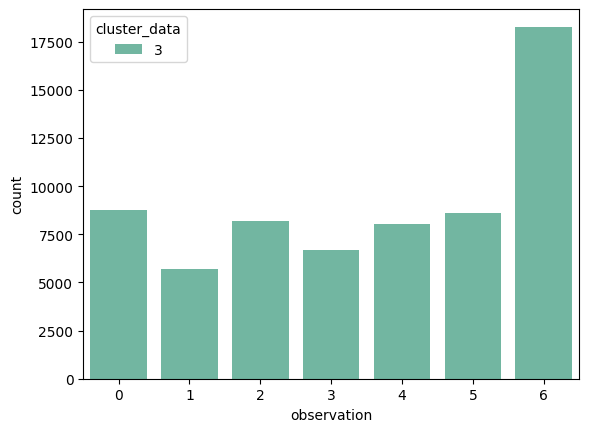

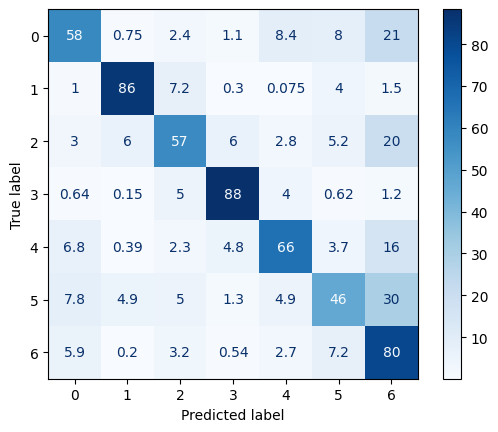

{'average_accuracy': 0.6867710544413933, 'average_f1_macro': np.float64(0.6840392048255062), 'average_f1_micro': np.float64(0.6867710544413933), 'average_auc': np.float64(0.9178542032615215), 'average_acc_kelas_generatif': 0.8851332013553691, 'average_acc_fase_padi': 0.7152158036671542}
{'val_accuracy': 0.6942104678297588, 'val_f1_macro': np.float64(0.6950197926047144), 'val_f1_micro': np.float64(0.6942104678297588), 'val_auc': np.float64(0.9247747775909195), 'val_acc_kelas_generatif': 0.8836317135549873, 'val_acc_fase_padi': 0.728387675740353, 'val_relative_acc': np.float64(95.05698005698005)}
CLUSTER:  4


[I 2024-10-17 09:57:29,802] A new study created in memory with name: no-name-63973edc-84cb-4f9e-b631-b5c3675f2b1e


[6 5 1 3 4 0 2]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-17 09:58:01,163] Trial 0 finished with value: 0.7715173955687766 and parameters: {'max_depth': 8, 'learning_rate': 0.06558026369517073, 'reg_lambda': 4.098944573452619, 'min_child_weight': 56}. Best is trial 0 with value: 0.7715173955687766.


[I 2024-10-17 09:58:34,094] Trial 1 finished with value: 0.7753820865922324 and parameters: {'max_depth': 10, 'learning_rate': 0.0895293638297826, 'reg_lambda': 4.112461940541927, 'min_child_weight': 55}. Best is trial 1 with value: 0.7753820865922324.


[I 2024-10-17 09:59:03,868] Trial 2 finished with value: 0.7759342422195196 and parameters: {'max_depth': 9, 'learning_rate': 0.07862582918174624, 'reg_lambda': 2.500390883434955, 'min_child_weight': 60}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 09:59:46,824] Trial 3 finished with value: 0.7739665551865412 and parameters: {'max_depth': 7, 'learning_rate': 0.04579885017500552, 'reg_lambda': 2.8501577277623804, 'min_child_weight': 54}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:00:15,748] Trial 4 finished with value: 0.7747603331457844 and parameters: {'max_depth': 9, 'learning_rate': 0.07393714234234144, 'reg_lambda': 1.3620386976047059, 'min_child_weight': 56}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:00:40,189] Trial 5 finished with value: 0.7741294053093309 and parameters: {'max_depth': 7, 'learning_rate': 0.09811074387994118, 'reg_lambda': 4.954050927192945, 'min_child_weight': 88}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:01:07,229] Trial 6 finished with value: 0.773376169951748 and parameters: {'max_depth': 7, 'learning_rate': 0.09061638895198218, 'reg_lambda': 2.081987854254018, 'min_child_weight': 97}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:02:09,046] Trial 7 finished with value: 0.7732812155373431 and parameters: {'max_depth': 10, 'learning_rate': 0.032167982852202986, 'reg_lambda': 3.0995041493494306, 'min_child_weight': 73}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:02:53,269] Trial 8 finished with value: 0.7728289555794318 and parameters: {'max_depth': 10, 'learning_rate': 0.04608392640699139, 'reg_lambda': 4.601877552044241, 'min_child_weight': 82}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:03:51,073] Trial 9 finished with value: 0.7739045438784844 and parameters: {'max_depth': 9, 'learning_rate': 0.034490841920552455, 'reg_lambda': 3.3134395887888632, 'min_child_weight': 77}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:05:04,854] Trial 10 finished with value: 0.7674862338894117 and parameters: {'max_depth': 6, 'learning_rate': 0.01583200888055431, 'reg_lambda': 0.3792595919651367, 'min_child_weight': 67}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:05:32,208] Trial 11 finished with value: 0.7747681981174731 and parameters: {'max_depth': 9, 'learning_rate': 0.0818542612328984, 'reg_lambda': 3.7748701932544364, 'min_child_weight': 63}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:06:00,559] Trial 12 finished with value: 0.7752603880998153 and parameters: {'max_depth': 10, 'learning_rate': 0.07130146310645487, 'reg_lambda': 2.0824066460062642, 'min_child_weight': 64}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:06:26,865] Trial 13 finished with value: 0.7753152522693215 and parameters: {'max_depth': 9, 'learning_rate': 0.08438725477224783, 'reg_lambda': 1.2146646599476243, 'min_child_weight': 50}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:06:45,212] Trial 14 finished with value: 0.7747776982381948 and parameters: {'max_depth': 8, 'learning_rate': 0.09997576157136737, 'reg_lambda': 3.8912746949096073, 'min_child_weight': 61}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:07:11,377] Trial 15 finished with value: 0.7755038995307632 and parameters: {'max_depth': 10, 'learning_rate': 0.06601911041257762, 'reg_lambda': 2.143919556901375, 'min_child_weight': 71}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:07:44,324] Trial 16 finished with value: 0.773611795286688 and parameters: {'max_depth': 8, 'learning_rate': 0.05951440319753953, 'reg_lambda': 2.280618695946414, 'min_child_weight': 71}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:08:23,246] Trial 17 finished with value: 0.7739547101570242 and parameters: {'max_depth': 9, 'learning_rate': 0.053138270736473626, 'reg_lambda': 1.4875235133725155, 'min_child_weight': 81}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:08:53,228] Trial 18 finished with value: 0.7733300345810935 and parameters: {'max_depth': 10, 'learning_rate': 0.07339437935651398, 'reg_lambda': 0.5858366715730423, 'min_child_weight': 68}. Best is trial 2 with value: 0.7759342422195196.


[I 2024-10-17 10:09:31,562] Trial 19 finished with value: 0.7737774662916173 and parameters: {'max_depth': 9, 'learning_rate': 0.06167088453362796, 'reg_lambda': 2.670853106953388, 'min_child_weight': 76}. Best is trial 2 with value: 0.7759342422195196.


Best Parameters: {'max_depth': 9, 'learning_rate': 0.07862582918174624, 'reg_lambda': 2.500390883434955, 'min_child_weight': 60}
Best Score: 0.7759342422195196
Start the modelling


[0]	train-mlogloss:1.79771	eval-mlogloss:1.80888


[100]	train-mlogloss:0.24020	eval-mlogloss:0.57935


[200]	train-mlogloss:0.11951	eval-mlogloss:0.55758


[300]	train-mlogloss:0.07034	eval-mlogloss:0.56172


[400]	train-mlogloss:0.04767	eval-mlogloss:0.57307


[500]	train-mlogloss:0.03513	eval-mlogloss:0.58505


[600]	train-mlogloss:0.02803	eval-mlogloss:0.59646


[700]	train-mlogloss:0.02308	eval-mlogloss:0.60602


[800]	train-mlogloss:0.01960	eval-mlogloss:0.61517


[900]	train-mlogloss:0.01711	eval-mlogloss:0.62309


[1000]	train-mlogloss:0.01521	eval-mlogloss:0.63075


[1100]	train-mlogloss:0.01370	eval-mlogloss:0.63658


[1200]	train-mlogloss:0.01252	eval-mlogloss:0.64318


[1215]	train-mlogloss:0.01237	eval-mlogloss:0.64394


[0]	train-mlogloss:1.79769	eval-mlogloss:1.80825


[100]	train-mlogloss:0.23814	eval-mlogloss:0.58427


[200]	train-mlogloss:0.12024	eval-mlogloss:0.56721


[300]	train-mlogloss:0.07130	eval-mlogloss:0.57547


[400]	train-mlogloss:0.04783	eval-mlogloss:0.58924


[500]	train-mlogloss:0.03525	eval-mlogloss:0.60450


[600]	train-mlogloss:0.02742	eval-mlogloss:0.61841


[700]	train-mlogloss:0.02271	eval-mlogloss:0.63004


[800]	train-mlogloss:0.01930	eval-mlogloss:0.64200


[900]	train-mlogloss:0.01685	eval-mlogloss:0.65129


[1000]	train-mlogloss:0.01494	eval-mlogloss:0.66055


[1100]	train-mlogloss:0.01345	eval-mlogloss:0.66867


[1200]	train-mlogloss:0.01229	eval-mlogloss:0.67616


[1209]	train-mlogloss:0.01220	eval-mlogloss:0.67670


[0]	train-mlogloss:1.79865	eval-mlogloss:1.80790


[100]	train-mlogloss:0.24271	eval-mlogloss:0.57002


[200]	train-mlogloss:0.12420	eval-mlogloss:0.54701


[300]	train-mlogloss:0.07224	eval-mlogloss:0.55220


[400]	train-mlogloss:0.04955	eval-mlogloss:0.56258


[500]	train-mlogloss:0.03667	eval-mlogloss:0.57472


[600]	train-mlogloss:0.02895	eval-mlogloss:0.58583


[700]	train-mlogloss:0.02391	eval-mlogloss:0.59623


[800]	train-mlogloss:0.02025	eval-mlogloss:0.60483


[900]	train-mlogloss:0.01762	eval-mlogloss:0.61255


[1000]	train-mlogloss:0.01559	eval-mlogloss:0.61960


[1100]	train-mlogloss:0.01401	eval-mlogloss:0.62699


[1200]	train-mlogloss:0.01277	eval-mlogloss:0.63413


[1217]	train-mlogloss:0.01258	eval-mlogloss:0.63527


[0]	train-mlogloss:1.79678	eval-mlogloss:1.80484


[50]	train-mlogloss:0.41295	eval-mlogloss:0.62131


[100]	train-mlogloss:0.26982	eval-mlogloss:0.55004


[150]	train-mlogloss:0.19593	eval-mlogloss:0.53013


[200]	train-mlogloss:0.14555	eval-mlogloss:0.52224


[250]	train-mlogloss:0.11203	eval-mlogloss:0.52034


[300]	train-mlogloss:0.08824	eval-mlogloss:0.52109


[313]	train-mlogloss:0.08249	eval-mlogloss:0.52159



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.68      0.57      0.62      6098
           1       0.88      0.92      0.90      8700
           2       0.87      0.88      0.88      5180
           3       0.92      0.94      0.93      9182
           4       0.79      0.69      0.74      5679
           5       0.63      0.52      0.57      5935
           6       0.82      0.96      0.88     12277

    accuracy                           0.82     53051
   macro avg       0.80      0.78      0.79     53051
weighted avg       0.81      0.82      0.81     53051



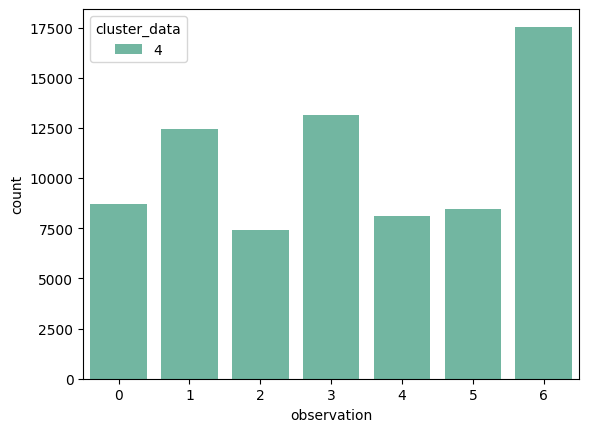

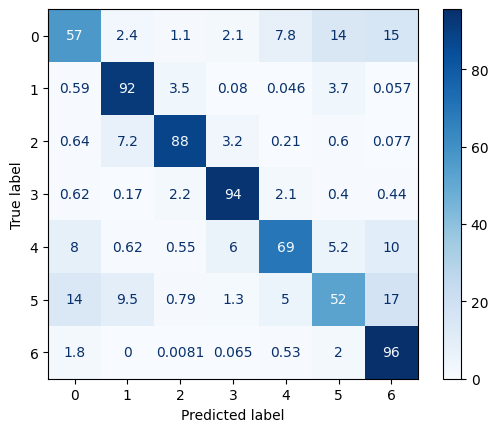

{'average_accuracy': 0.8101605408108344, 'average_f1_macro': np.float64(0.7768906102093771), 'average_f1_micro': np.float64(0.8101605408108344), 'average_auc': np.float64(0.9560624605423907), 'average_acc_kelas_generatif': 0.9402774677060272, 'average_acc_fase_padi': 0.8666073177720967}
{'val_accuracy': 0.8190986032308534, 'val_f1_macro': np.float64(0.7884854487874197), 'val_f1_micro': np.float64(0.8190986032308534), 'val_auc': np.float64(0.961577026398665), 'val_acc_kelas_generatif': 0.9402091047702026, 'val_acc_fase_padi': 0.8746042239309697, 'val_relative_acc': np.float64(99.060513080062)}
CLUSTER:  5


[I 2024-10-17 10:11:27,801] A new study created in memory with name: no-name-979a2310-1b0a-40d6-ad79-7430e28d5c83


[6 2 3 0 4 5 1]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-17 10:12:26,429] Trial 0 finished with value: 0.7858686431210788 and parameters: {'max_depth': 10, 'learning_rate': 0.02513950762399547, 'reg_lambda': 3.133022934419882, 'min_child_weight': 79}. Best is trial 0 with value: 0.7858686431210788.


[I 2024-10-17 10:12:51,836] Trial 1 finished with value: 0.781674615912341 and parameters: {'max_depth': 7, 'learning_rate': 0.08906842776673253, 'reg_lambda': 3.0959431945005784, 'min_child_weight': 71}. Best is trial 0 with value: 0.7858686431210788.


[I 2024-10-17 10:14:12,547] Trial 2 finished with value: 0.7823521000676367 and parameters: {'max_depth': 7, 'learning_rate': 0.02494276513239777, 'reg_lambda': 1.0226271030852423, 'min_child_weight': 72}. Best is trial 0 with value: 0.7858686431210788.


[I 2024-10-17 10:14:40,968] Trial 3 finished with value: 0.78732856396515 and parameters: {'max_depth': 10, 'learning_rate': 0.07149350666439877, 'reg_lambda': 2.344678421900885, 'min_child_weight': 66}. Best is trial 3 with value: 0.78732856396515.


[I 2024-10-17 10:15:11,233] Trial 4 finished with value: 0.7856150373142526 and parameters: {'max_depth': 9, 'learning_rate': 0.06734464175978967, 'reg_lambda': 3.2467408091132586, 'min_child_weight': 80}. Best is trial 3 with value: 0.78732856396515.


[I 2024-10-17 10:15:58,513] Trial 5 finished with value: 0.7876450206507118 and parameters: {'max_depth': 10, 'learning_rate': 0.03960937852336819, 'reg_lambda': 2.121206405326418, 'min_child_weight': 52}. Best is trial 5 with value: 0.7876450206507118.


[I 2024-10-17 10:16:29,441] Trial 6 finished with value: 0.7843659153183816 and parameters: {'max_depth': 10, 'learning_rate': 0.07103914043306676, 'reg_lambda': 1.8729179626940025, 'min_child_weight': 97}. Best is trial 5 with value: 0.7876450206507118.


[I 2024-10-17 10:17:00,698] Trial 7 finished with value: 0.7804764241820502 and parameters: {'max_depth': 7, 'learning_rate': 0.06530648927612011, 'reg_lambda': 1.152414750147914, 'min_child_weight': 85}. Best is trial 5 with value: 0.7876450206507118.


[I 2024-10-17 10:17:37,286] Trial 8 finished with value: 0.7838612944769526 and parameters: {'max_depth': 7, 'learning_rate': 0.042163772450748156, 'reg_lambda': 4.197936565513824, 'min_child_weight': 52}. Best is trial 5 with value: 0.7876450206507118.


[I 2024-10-17 10:18:03,043] Trial 9 finished with value: 0.7870781994272554 and parameters: {'max_depth': 10, 'learning_rate': 0.07830654416162472, 'reg_lambda': 0.24009465791091947, 'min_child_weight': 64}. Best is trial 5 with value: 0.7876450206507118.


[I 2024-10-17 10:18:43,134] Trial 10 finished with value: 0.7855320226812849 and parameters: {'max_depth': 8, 'learning_rate': 0.047663538876444825, 'reg_lambda': 4.910308622043736, 'min_child_weight': 51}. Best is trial 5 with value: 0.7876450206507118.


[I 2024-10-17 10:19:26,379] Trial 11 finished with value: 0.7840642059127059 and parameters: {'max_depth': 9, 'learning_rate': 0.04033827601762764, 'reg_lambda': 1.8478244977918297, 'min_child_weight': 61}. Best is trial 5 with value: 0.7876450206507118.


[I 2024-10-17 10:21:22,662] Trial 12 finished with value: 0.7830252600467698 and parameters: {'max_depth': 9, 'learning_rate': 0.010101024797307876, 'reg_lambda': 2.177036286417862, 'min_child_weight': 60}. Best is trial 5 with value: 0.7876450206507118.


[I 2024-10-17 10:21:42,997] Trial 13 finished with value: 0.7846523661267443 and parameters: {'max_depth': 9, 'learning_rate': 0.09613089388727283, 'reg_lambda': 2.6024337621999, 'min_child_weight': 56}. Best is trial 5 with value: 0.7876450206507118.


[I 2024-10-17 10:22:15,861] Trial 14 finished with value: 0.7810411168491522 and parameters: {'max_depth': 6, 'learning_rate': 0.05628284541229207, 'reg_lambda': 1.290735196321893, 'min_child_weight': 66}. Best is trial 5 with value: 0.7876450206507118.


[I 2024-10-17 10:22:42,788] Trial 15 finished with value: 0.7844865863653192 and parameters: {'max_depth': 10, 'learning_rate': 0.05578370241442269, 'reg_lambda': 3.885784443774564, 'min_child_weight': 90}. Best is trial 5 with value: 0.7876450206507118.


[I 2024-10-17 10:23:40,304] Trial 16 finished with value: 0.7844505978447169 and parameters: {'max_depth': 8, 'learning_rate': 0.02983042173319151, 'reg_lambda': 2.5184504196096578, 'min_child_weight': 68}. Best is trial 5 with value: 0.7876450206507118.


[I 2024-10-17 10:24:13,002] Trial 17 finished with value: 0.7862445970598331 and parameters: {'max_depth': 10, 'learning_rate': 0.08387208175261543, 'reg_lambda': 0.6046334599284333, 'min_child_weight': 57}. Best is trial 5 with value: 0.7876450206507118.


[I 2024-10-17 10:25:06,318] Trial 18 finished with value: 0.7849302230603792 and parameters: {'max_depth': 9, 'learning_rate': 0.034661721146100874, 'reg_lambda': 1.7023654973015416, 'min_child_weight': 76}. Best is trial 5 with value: 0.7876450206507118.


[I 2024-10-17 10:26:42,510] Trial 19 finished with value: 0.7837173930912363 and parameters: {'max_depth': 8, 'learning_rate': 0.012749317858004726, 'reg_lambda': 2.44464146200897, 'min_child_weight': 51}. Best is trial 5 with value: 0.7876450206507118.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.03960937852336819, 'reg_lambda': 2.121206405326418, 'min_child_weight': 52}
Best Score: 0.7876450206507118
Start the modelling


[0]	train-mlogloss:1.86473	eval-mlogloss:1.87403


[100]	train-mlogloss:0.35148	eval-mlogloss:0.65436


[200]	train-mlogloss:0.21160	eval-mlogloss:0.59981


[300]	train-mlogloss:0.14327	eval-mlogloss:0.58855


[400]	train-mlogloss:0.10288	eval-mlogloss:0.58797


[500]	train-mlogloss:0.07847	eval-mlogloss:0.59316


[600]	train-mlogloss:0.06277	eval-mlogloss:0.60075


[700]	train-mlogloss:0.05089	eval-mlogloss:0.60771


[800]	train-mlogloss:0.04317	eval-mlogloss:0.61525


[900]	train-mlogloss:0.03690	eval-mlogloss:0.62300


[1000]	train-mlogloss:0.03223	eval-mlogloss:0.63072


[1100]	train-mlogloss:0.02857	eval-mlogloss:0.63810


[1200]	train-mlogloss:0.02558	eval-mlogloss:0.64477


[1300]	train-mlogloss:0.02328	eval-mlogloss:0.65121


[1371]	train-mlogloss:0.02190	eval-mlogloss:0.65550


[0]	train-mlogloss:1.86401	eval-mlogloss:1.87477


[100]	train-mlogloss:0.33888	eval-mlogloss:0.67087


[200]	train-mlogloss:0.19970	eval-mlogloss:0.61547


[300]	train-mlogloss:0.13644	eval-mlogloss:0.60881


[400]	train-mlogloss:0.09907	eval-mlogloss:0.61141


[500]	train-mlogloss:0.07514	eval-mlogloss:0.61788


[600]	train-mlogloss:0.05957	eval-mlogloss:0.62542


[700]	train-mlogloss:0.04908	eval-mlogloss:0.63464


[800]	train-mlogloss:0.04145	eval-mlogloss:0.64381


[900]	train-mlogloss:0.03571	eval-mlogloss:0.65250


[1000]	train-mlogloss:0.03148	eval-mlogloss:0.66040


[1100]	train-mlogloss:0.02781	eval-mlogloss:0.66878


[1200]	train-mlogloss:0.02488	eval-mlogloss:0.67593


[1300]	train-mlogloss:0.02257	eval-mlogloss:0.68327


[1318]	train-mlogloss:0.02221	eval-mlogloss:0.68446


[0]	train-mlogloss:1.86516	eval-mlogloss:1.87393


[100]	train-mlogloss:0.34276	eval-mlogloss:0.65542


[200]	train-mlogloss:0.20824	eval-mlogloss:0.60223


[300]	train-mlogloss:0.13936	eval-mlogloss:0.59349


[400]	train-mlogloss:0.10042	eval-mlogloss:0.59416


[500]	train-mlogloss:0.07456	eval-mlogloss:0.60017


[600]	train-mlogloss:0.05893	eval-mlogloss:0.60745


[700]	train-mlogloss:0.04844	eval-mlogloss:0.61519


[800]	train-mlogloss:0.04073	eval-mlogloss:0.62358


[900]	train-mlogloss:0.03487	eval-mlogloss:0.63248


[1000]	train-mlogloss:0.03074	eval-mlogloss:0.63999


[1100]	train-mlogloss:0.02727	eval-mlogloss:0.64727


[1200]	train-mlogloss:0.02443	eval-mlogloss:0.65466


[1300]	train-mlogloss:0.02219	eval-mlogloss:0.66118


[1316]	train-mlogloss:0.02185	eval-mlogloss:0.66227


[0]	train-mlogloss:1.86365	eval-mlogloss:1.87226


[50]	train-mlogloss:0.60460	eval-mlogloss:0.80355


[100]	train-mlogloss:0.36811	eval-mlogloss:0.64555


[150]	train-mlogloss:0.28152	eval-mlogloss:0.60558


[200]	train-mlogloss:0.23375	eval-mlogloss:0.59161


[250]	train-mlogloss:0.19831	eval-mlogloss:0.58447


[300]	train-mlogloss:0.16937	eval-mlogloss:0.58063


[350]	train-mlogloss:0.14563	eval-mlogloss:0.57864


[400]	train-mlogloss:0.12443	eval-mlogloss:0.57767


[450]	train-mlogloss:0.10757	eval-mlogloss:0.57805


[459]	train-mlogloss:0.10456	eval-mlogloss:0.57822



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.78      0.66      0.72      5289
           1       0.92      0.95      0.93      9451
           2       0.89      0.80      0.84      5054
           3       0.93      0.96      0.95      7111
           4       0.76      0.64      0.70      6065
           5       0.74      0.56      0.64      5433
           6       0.72      0.87      0.79     13707

    accuracy                           0.81     52110
   macro avg       0.82      0.78      0.79     52110
weighted avg       0.81      0.81      0.81     52110



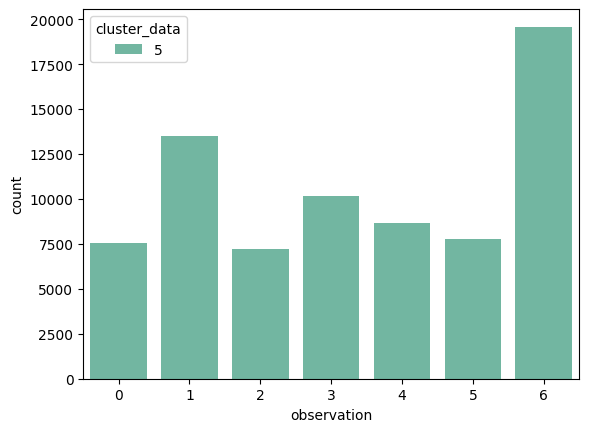

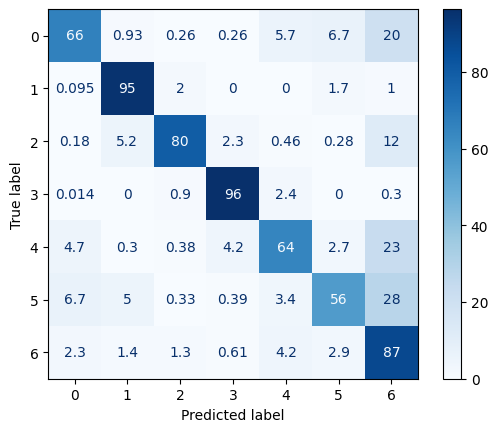

{'average_accuracy': 0.8061973849185026, 'average_f1_macro': np.float64(0.7870264732565349), 'average_f1_micro': np.float64(0.8061973849185026), 'average_auc': np.float64(0.9514522737273445), 'average_acc_kelas_generatif': 0.9570067750151919, 'average_acc_fase_padi': 0.8503750995700449}
{'val_accuracy': 0.8112454423335252, 'val_f1_macro': np.float64(0.7941789464474989), 'val_f1_micro': np.float64(0.8112454423335252), 'val_auc': np.float64(0.9543492719628822), 'val_acc_kelas_generatif': 0.9641400646885108, 'val_acc_fase_padi': 0.8594342689931722, 'val_relative_acc': np.float64(99.59356654045229)}
CLUSTER:  6


[I 2024-10-17 10:29:01,264] A new study created in memory with name: no-name-b3b8b963-d006-4f3d-b37d-742d6d2b178f


[6 5 1 2 3 0 4]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-17 10:30:09,681] Trial 0 finished with value: 0.9485457512864804 and parameters: {'max_depth': 7, 'learning_rate': 0.05247209916418158, 'reg_lambda': 1.56978959921483, 'min_child_weight': 85}. Best is trial 0 with value: 0.9485457512864804.


[I 2024-10-17 10:30:43,450] Trial 1 finished with value: 0.946749512186623 and parameters: {'max_depth': 10, 'learning_rate': 0.08416090771093279, 'reg_lambda': 1.5144060595727513, 'min_child_weight': 83}. Best is trial 0 with value: 0.9485457512864804.


[I 2024-10-17 10:32:10,398] Trial 2 finished with value: 0.9447740195350138 and parameters: {'max_depth': 7, 'learning_rate': 0.017480539769757063, 'reg_lambda': 1.305864948065636, 'min_child_weight': 87}. Best is trial 0 with value: 0.9485457512864804.


[I 2024-10-17 10:32:43,869] Trial 3 finished with value: 0.9466197372660073 and parameters: {'max_depth': 9, 'learning_rate': 0.06551894395483682, 'reg_lambda': 3.861473196704338, 'min_child_weight': 74}. Best is trial 0 with value: 0.9485457512864804.


[I 2024-10-17 10:33:11,967] Trial 4 finished with value: 0.9477960219481391 and parameters: {'max_depth': 8, 'learning_rate': 0.0967211908703451, 'reg_lambda': 1.039128487677085, 'min_child_weight': 77}. Best is trial 0 with value: 0.9485457512864804.


[I 2024-10-17 10:33:48,815] Trial 5 finished with value: 0.9480502429991752 and parameters: {'max_depth': 7, 'learning_rate': 0.08037852675307845, 'reg_lambda': 4.737986887590666, 'min_child_weight': 88}. Best is trial 0 with value: 0.9485457512864804.


[I 2024-10-17 10:35:17,705] Trial 6 finished with value: 0.9483289743542856 and parameters: {'max_depth': 7, 'learning_rate': 0.03290357781395146, 'reg_lambda': 3.312773104761249, 'min_child_weight': 78}. Best is trial 0 with value: 0.9485457512864804.


[I 2024-10-17 10:36:04,401] Trial 7 finished with value: 0.9482978616041621 and parameters: {'max_depth': 7, 'learning_rate': 0.06784547791248272, 'reg_lambda': 0.5808155244268641, 'min_child_weight': 97}. Best is trial 0 with value: 0.9485457512864804.


[I 2024-10-17 10:36:37,232] Trial 8 finished with value: 0.9472597649028579 and parameters: {'max_depth': 9, 'learning_rate': 0.08538211841801378, 'reg_lambda': 1.3293567004811946, 'min_child_weight': 62}. Best is trial 0 with value: 0.9485457512864804.


[I 2024-10-17 10:37:36,437] Trial 9 finished with value: 0.9479629671849942 and parameters: {'max_depth': 8, 'learning_rate': 0.060945189927485245, 'reg_lambda': 0.9170200297715893, 'min_child_weight': 76}. Best is trial 0 with value: 0.9485457512864804.


[I 2024-10-17 10:38:29,061] Trial 10 finished with value: 0.9485528564841662 and parameters: {'max_depth': 6, 'learning_rate': 0.041858873990675914, 'reg_lambda': 2.392045980582255, 'min_child_weight': 61}. Best is trial 10 with value: 0.9485528564841662.


[I 2024-10-17 10:39:35,670] Trial 11 finished with value: 0.9494917530394212 and parameters: {'max_depth': 6, 'learning_rate': 0.041140647369408784, 'reg_lambda': 2.607126678745794, 'min_child_weight': 50}. Best is trial 11 with value: 0.9494917530394212.


[I 2024-10-17 10:40:42,285] Trial 12 finished with value: 0.9488933030816707 and parameters: {'max_depth': 6, 'learning_rate': 0.03887486576267117, 'reg_lambda': 2.69493653197208, 'min_child_weight': 53}. Best is trial 11 with value: 0.9494917530394212.


[I 2024-10-17 10:42:03,542] Trial 13 finished with value: 0.9477206743271221 and parameters: {'max_depth': 6, 'learning_rate': 0.0268645082356953, 'reg_lambda': 2.5763084489803356, 'min_child_weight': 53}. Best is trial 11 with value: 0.9494917530394212.


[I 2024-10-17 10:42:57,738] Trial 14 finished with value: 0.9495455037648194 and parameters: {'max_depth': 6, 'learning_rate': 0.04570561557789333, 'reg_lambda': 2.487572955608293, 'min_child_weight': 50}. Best is trial 14 with value: 0.9495455037648194.


[I 2024-10-17 10:44:14,157] Trial 15 finished with value: 0.9439137211354569 and parameters: {'max_depth': 6, 'learning_rate': 0.015737319244865003, 'reg_lambda': 2.0669704163888096, 'min_child_weight': 61}. Best is trial 14 with value: 0.9495455037648194.


[I 2024-10-17 10:45:14,654] Trial 16 finished with value: 0.9491144420116555 and parameters: {'max_depth': 6, 'learning_rate': 0.05128607473470873, 'reg_lambda': 3.383359341101727, 'min_child_weight': 50}. Best is trial 14 with value: 0.9495455037648194.


[I 2024-10-17 10:46:12,360] Trial 17 finished with value: 0.9476252865836776 and parameters: {'max_depth': 8, 'learning_rate': 0.0437956473989296, 'reg_lambda': 0.154525797575074, 'min_child_weight': 65}. Best is trial 14 with value: 0.9495455037648194.


[I 2024-10-17 10:47:46,288] Trial 18 finished with value: 0.9468658028781726 and parameters: {'max_depth': 9, 'learning_rate': 0.02624434132336775, 'reg_lambda': 3.2587046946365463, 'min_child_weight': 69}. Best is trial 14 with value: 0.9495455037648194.


[I 2024-10-17 10:49:03,078] Trial 19 finished with value: 0.9390013727139785 and parameters: {'max_depth': 6, 'learning_rate': 0.010479781752189152, 'reg_lambda': 4.084246743613747, 'min_child_weight': 56}. Best is trial 14 with value: 0.9495455037648194.


Best Parameters: {'max_depth': 6, 'learning_rate': 0.04570561557789333, 'reg_lambda': 2.487572955608293, 'min_child_weight': 50}
Best Score: 0.9495455037648194
Start the modelling


[0]	train-mlogloss:1.82781	eval-mlogloss:1.83164


[100]	train-mlogloss:0.15468	eval-mlogloss:0.23048


[200]	train-mlogloss:0.07042	eval-mlogloss:0.16352


[300]	train-mlogloss:0.04115	eval-mlogloss:0.14575


[400]	train-mlogloss:0.02692	eval-mlogloss:0.13835


[500]	train-mlogloss:0.01908	eval-mlogloss:0.13553


[600]	train-mlogloss:0.01451	eval-mlogloss:0.13431


[700]	train-mlogloss:0.01160	eval-mlogloss:0.13372


[800]	train-mlogloss:0.00966	eval-mlogloss:0.13403


[900]	train-mlogloss:0.00829	eval-mlogloss:0.13446


[1000]	train-mlogloss:0.00729	eval-mlogloss:0.13481


[1100]	train-mlogloss:0.00651	eval-mlogloss:0.13532


[1200]	train-mlogloss:0.00591	eval-mlogloss:0.13576


[1300]	train-mlogloss:0.00544	eval-mlogloss:0.13637


[1400]	train-mlogloss:0.00506	eval-mlogloss:0.13688


[1500]	train-mlogloss:0.00476	eval-mlogloss:0.13730


[1600]	train-mlogloss:0.00450	eval-mlogloss:0.13781


[1700]	train-mlogloss:0.00428	eval-mlogloss:0.13831


[1702]	train-mlogloss:0.00427	eval-mlogloss:0.13831


[0]	train-mlogloss:1.82920	eval-mlogloss:1.83279


[100]	train-mlogloss:0.15866	eval-mlogloss:0.23224


[200]	train-mlogloss:0.07443	eval-mlogloss:0.16406


[300]	train-mlogloss:0.04415	eval-mlogloss:0.14560


[400]	train-mlogloss:0.02899	eval-mlogloss:0.13873


[500]	train-mlogloss:0.02034	eval-mlogloss:0.13580


[600]	train-mlogloss:0.01501	eval-mlogloss:0.13423


[700]	train-mlogloss:0.01188	eval-mlogloss:0.13422


[800]	train-mlogloss:0.00981	eval-mlogloss:0.13479


[900]	train-mlogloss:0.00840	eval-mlogloss:0.13532


[1000]	train-mlogloss:0.00736	eval-mlogloss:0.13576


[1100]	train-mlogloss:0.00658	eval-mlogloss:0.13657


[1200]	train-mlogloss:0.00598	eval-mlogloss:0.13731


[1300]	train-mlogloss:0.00550	eval-mlogloss:0.13823


[1400]	train-mlogloss:0.00511	eval-mlogloss:0.13876


[1500]	train-mlogloss:0.00479	eval-mlogloss:0.13939


[1600]	train-mlogloss:0.00453	eval-mlogloss:0.14003


[1630]	train-mlogloss:0.00446	eval-mlogloss:0.14012


[0]	train-mlogloss:1.82986	eval-mlogloss:1.83189


[100]	train-mlogloss:0.15974	eval-mlogloss:0.22859


[200]	train-mlogloss:0.07329	eval-mlogloss:0.15815


[300]	train-mlogloss:0.04397	eval-mlogloss:0.13942


[400]	train-mlogloss:0.02864	eval-mlogloss:0.13140


[500]	train-mlogloss:0.02014	eval-mlogloss:0.12789


[600]	train-mlogloss:0.01513	eval-mlogloss:0.12642


[700]	train-mlogloss:0.01196	eval-mlogloss:0.12568


[800]	train-mlogloss:0.00992	eval-mlogloss:0.12570


[900]	train-mlogloss:0.00844	eval-mlogloss:0.12630


[1000]	train-mlogloss:0.00740	eval-mlogloss:0.12684


[1100]	train-mlogloss:0.00661	eval-mlogloss:0.12731


[1200]	train-mlogloss:0.00601	eval-mlogloss:0.12790


[1300]	train-mlogloss:0.00554	eval-mlogloss:0.12844


[1400]	train-mlogloss:0.00516	eval-mlogloss:0.12895


[1500]	train-mlogloss:0.00484	eval-mlogloss:0.12974


[1600]	train-mlogloss:0.00457	eval-mlogloss:0.13019


[1700]	train-mlogloss:0.00435	eval-mlogloss:0.13066


[1721]	train-mlogloss:0.00430	eval-mlogloss:0.13077


[0]	train-mlogloss:1.82874	eval-mlogloss:1.83083


[50]	train-mlogloss:0.36160	eval-mlogloss:0.40408


[100]	train-mlogloss:0.16581	eval-mlogloss:0.22022


[150]	train-mlogloss:0.10995	eval-mlogloss:0.17143


[200]	train-mlogloss:0.08170	eval-mlogloss:0.14985


[250]	train-mlogloss:0.06375	eval-mlogloss:0.13762


[300]	train-mlogloss:0.05130	eval-mlogloss:0.12982


[350]	train-mlogloss:0.04186	eval-mlogloss:0.12429


[400]	train-mlogloss:0.03485	eval-mlogloss:0.12055


[450]	train-mlogloss:0.02929	eval-mlogloss:0.11776


[500]	train-mlogloss:0.02495	eval-mlogloss:0.11585


[550]	train-mlogloss:0.02151	eval-mlogloss:0.11431


[600]	train-mlogloss:0.01869	eval-mlogloss:0.11313


[650]	train-mlogloss:0.01637	eval-mlogloss:0.11236


[700]	train-mlogloss:0.01449	eval-mlogloss:0.11167


[750]	train-mlogloss:0.01298	eval-mlogloss:0.11136


[800]	train-mlogloss:0.01170	eval-mlogloss:0.11121


[850]	train-mlogloss:0.01069	eval-mlogloss:0.11111


[900]	train-mlogloss:0.00977	eval-mlogloss:0.11103


[939]	train-mlogloss:0.00916	eval-mlogloss:0.11107



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     11868
           1       0.94      0.93      0.93     11172
           2       0.94      0.95      0.95     10544
           3       0.97      0.97      0.97     11514
           4       0.96      0.97      0.96      6917
           5       0.92      0.94      0.93      7097
           6       0.98      0.98      0.98     13415

    accuracy                           0.96     72527
   macro avg       0.96      0.96      0.96     72527
weighted avg       0.96      0.96      0.96     72527



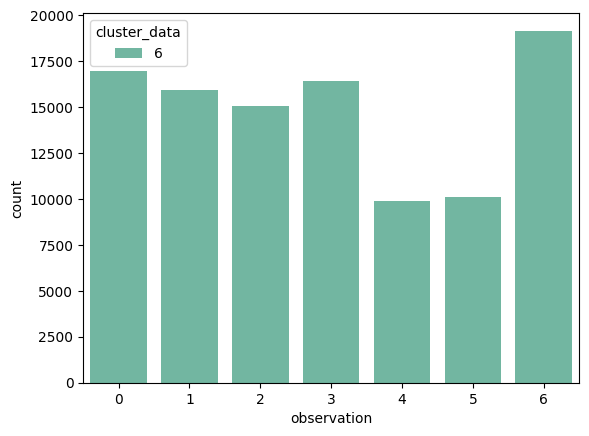

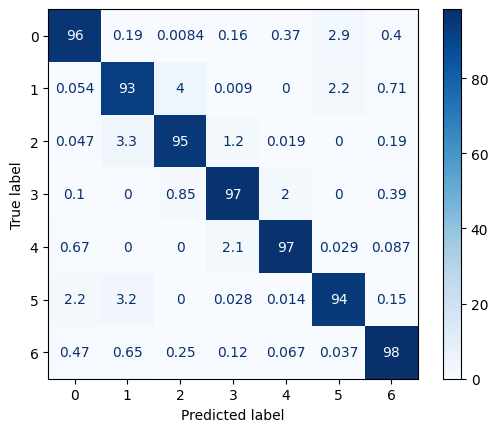

{'average_accuracy': 0.9528359553453657, 'average_f1_macro': np.float64(0.9503006693633366), 'average_f1_micro': np.float64(0.9528359553453657), 'average_auc': np.float64(0.99816027160768), 'average_acc_kelas_generatif': 0.9574371944771075, 'average_acc_fase_padi': 0.9480384612214529}
{'val_accuracy': 0.9592841286693231, 'val_f1_macro': np.float64(0.9572411859460955), 'val_f1_micro': np.float64(0.9592841286693231), 'val_auc': np.float64(0.9985744499365162), 'val_acc_kelas_generatif': 0.9661281917665451, 'val_acc_fase_padi': 0.953570627942312, 'val_relative_acc': np.float64(99.98933014660379)}
CLUSTER:  7


[I 2024-10-17 10:51:38,624] A new study created in memory with name: no-name-2a7cb49f-4ad8-4d09-8fbc-2e89966c4a17


[1 5 6 3 2 4 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-17 10:52:29,636] Trial 0 finished with value: 0.6901547709148187 and parameters: {'max_depth': 8, 'learning_rate': 0.046966963165057725, 'reg_lambda': 0.8863658256343386, 'min_child_weight': 56}. Best is trial 0 with value: 0.6901547709148187.


[I 2024-10-17 10:52:59,076] Trial 1 finished with value: 0.687562347093467 and parameters: {'max_depth': 6, 'learning_rate': 0.09841611002068823, 'reg_lambda': 4.528325522891373, 'min_child_weight': 91}. Best is trial 0 with value: 0.6901547709148187.


[I 2024-10-17 10:53:36,547] Trial 2 finished with value: 0.693266894981432 and parameters: {'max_depth': 10, 'learning_rate': 0.05668742580785608, 'reg_lambda': 2.4848153629832277, 'min_child_weight': 91}. Best is trial 2 with value: 0.693266894981432.


[I 2024-10-17 10:54:03,800] Trial 3 finished with value: 0.6894370859635371 and parameters: {'max_depth': 8, 'learning_rate': 0.09989295504148006, 'reg_lambda': 2.308102315040542, 'min_child_weight': 70}. Best is trial 2 with value: 0.693266894981432.


[I 2024-10-17 10:54:41,121] Trial 4 finished with value: 0.690722905791653 and parameters: {'max_depth': 6, 'learning_rate': 0.07650963323528825, 'reg_lambda': 3.9794510665130187, 'min_child_weight': 83}. Best is trial 2 with value: 0.693266894981432.


[I 2024-10-17 10:56:07,336] Trial 5 finished with value: 0.6858421047844422 and parameters: {'max_depth': 6, 'learning_rate': 0.022791138704735904, 'reg_lambda': 3.2173471027497067, 'min_child_weight': 83}. Best is trial 2 with value: 0.693266894981432.


[I 2024-10-17 10:57:49,134] Trial 6 finished with value: 0.6887568434565464 and parameters: {'max_depth': 8, 'learning_rate': 0.018441759189083404, 'reg_lambda': 1.26346054095108, 'min_child_weight': 79}. Best is trial 2 with value: 0.693266894981432.


[I 2024-10-17 10:58:25,895] Trial 7 finished with value: 0.6940142947523102 and parameters: {'max_depth': 9, 'learning_rate': 0.07574784108075776, 'reg_lambda': 2.9632246858318747, 'min_child_weight': 55}. Best is trial 7 with value: 0.6940142947523102.


[I 2024-10-17 10:59:04,430] Trial 8 finished with value: 0.6915068108156622 and parameters: {'max_depth': 9, 'learning_rate': 0.05679758815700017, 'reg_lambda': 3.3971212529724912, 'min_child_weight': 93}. Best is trial 7 with value: 0.6940142947523102.


[I 2024-10-17 10:59:58,361] Trial 9 finished with value: 0.6937133311337904 and parameters: {'max_depth': 10, 'learning_rate': 0.04506034813262802, 'reg_lambda': 0.5930053162352402, 'min_child_weight': 61}. Best is trial 7 with value: 0.6940142947523102.


[I 2024-10-17 11:00:40,878] Trial 10 finished with value: 0.691986734676615 and parameters: {'max_depth': 9, 'learning_rate': 0.07615322012831749, 'reg_lambda': 1.9227080575771884, 'min_child_weight': 66}. Best is trial 7 with value: 0.6940142947523102.


[I 2024-10-17 11:01:44,040] Trial 11 finished with value: 0.6904363178076444 and parameters: {'max_depth': 10, 'learning_rate': 0.04136580467460544, 'reg_lambda': 0.5656201614212218, 'min_child_weight': 54}. Best is trial 7 with value: 0.6940142947523102.


[I 2024-10-17 11:02:20,915] Trial 12 finished with value: 0.6901334276697924 and parameters: {'max_depth': 9, 'learning_rate': 0.07361214523245015, 'reg_lambda': 1.6227140253091898, 'min_child_weight': 62}. Best is trial 7 with value: 0.6940142947523102.


[I 2024-10-17 11:03:34,340] Trial 13 finished with value: 0.6921522611447806 and parameters: {'max_depth': 10, 'learning_rate': 0.03262283660401319, 'reg_lambda': 0.2249660349050404, 'min_child_weight': 51}. Best is trial 7 with value: 0.6940142947523102.


[I 2024-10-17 11:04:07,263] Trial 14 finished with value: 0.6897642388887123 and parameters: {'max_depth': 9, 'learning_rate': 0.06587603028737515, 'reg_lambda': 3.3532827876342437, 'min_child_weight': 60}. Best is trial 7 with value: 0.6940142947523102.


[I 2024-10-17 11:04:35,985] Trial 15 finished with value: 0.6896337972529397 and parameters: {'max_depth': 7, 'learning_rate': 0.08731059581451059, 'reg_lambda': 2.8045789299197033, 'min_child_weight': 72}. Best is trial 7 with value: 0.6940142947523102.


[I 2024-10-17 11:05:39,210] Trial 16 finished with value: 0.6909051756236798 and parameters: {'max_depth': 10, 'learning_rate': 0.03953910355909118, 'reg_lambda': 4.894594794314916, 'min_child_weight': 50}. Best is trial 7 with value: 0.6940142947523102.


[I 2024-10-17 11:06:18,871] Trial 17 finished with value: 0.6907343710103772 and parameters: {'max_depth': 9, 'learning_rate': 0.0625835481892293, 'reg_lambda': 3.9162004218670594, 'min_child_weight': 63}. Best is trial 7 with value: 0.6940142947523102.


[I 2024-10-17 11:06:53,091] Trial 18 finished with value: 0.6887491225937192 and parameters: {'max_depth': 7, 'learning_rate': 0.08598995615362011, 'reg_lambda': 1.9606987360583648, 'min_child_weight': 57}. Best is trial 7 with value: 0.6940142947523102.


[I 2024-10-17 11:08:06,860] Trial 19 finished with value: 0.6922742597181054 and parameters: {'max_depth': 10, 'learning_rate': 0.02960776918717329, 'reg_lambda': 1.165753726990495, 'min_child_weight': 67}. Best is trial 7 with value: 0.6940142947523102.


Best Parameters: {'max_depth': 9, 'learning_rate': 0.07574784108075776, 'reg_lambda': 2.9632246858318747, 'min_child_weight': 55}
Best Score: 0.6940142947523102
Start the modelling


[0]	train-mlogloss:1.82667	eval-mlogloss:1.83485


[100]	train-mlogloss:0.36331	eval-mlogloss:0.70804


[200]	train-mlogloss:0.18941	eval-mlogloss:0.67460


[300]	train-mlogloss:0.10740	eval-mlogloss:0.67111


[400]	train-mlogloss:0.07051	eval-mlogloss:0.67922


[500]	train-mlogloss:0.05067	eval-mlogloss:0.68949


[600]	train-mlogloss:0.03861	eval-mlogloss:0.70013


[700]	train-mlogloss:0.03109	eval-mlogloss:0.71070


[800]	train-mlogloss:0.02598	eval-mlogloss:0.72043


[900]	train-mlogloss:0.02228	eval-mlogloss:0.72916


[1000]	train-mlogloss:0.01952	eval-mlogloss:0.73708


[1100]	train-mlogloss:0.01731	eval-mlogloss:0.74475


[1200]	train-mlogloss:0.01558	eval-mlogloss:0.75186


[1270]	train-mlogloss:0.01455	eval-mlogloss:0.75647


[0]	train-mlogloss:1.82740	eval-mlogloss:1.83601


[100]	train-mlogloss:0.35061	eval-mlogloss:0.70744


[200]	train-mlogloss:0.17874	eval-mlogloss:0.67776


[300]	train-mlogloss:0.10056	eval-mlogloss:0.67907


[400]	train-mlogloss:0.06585	eval-mlogloss:0.68814


[500]	train-mlogloss:0.04799	eval-mlogloss:0.70015


[600]	train-mlogloss:0.03700	eval-mlogloss:0.71220


[700]	train-mlogloss:0.02964	eval-mlogloss:0.72316


[800]	train-mlogloss:0.02471	eval-mlogloss:0.73368


[900]	train-mlogloss:0.02135	eval-mlogloss:0.74355


[1000]	train-mlogloss:0.01873	eval-mlogloss:0.75209


[1100]	train-mlogloss:0.01673	eval-mlogloss:0.76005


[1200]	train-mlogloss:0.01511	eval-mlogloss:0.76788


[1259]	train-mlogloss:0.01429	eval-mlogloss:0.77246


[0]	train-mlogloss:1.82678	eval-mlogloss:1.83281


[100]	train-mlogloss:0.36120	eval-mlogloss:0.71063


[200]	train-mlogloss:0.18509	eval-mlogloss:0.68219


[300]	train-mlogloss:0.10540	eval-mlogloss:0.68354


[400]	train-mlogloss:0.06918	eval-mlogloss:0.69384


[500]	train-mlogloss:0.05036	eval-mlogloss:0.70505


[600]	train-mlogloss:0.03876	eval-mlogloss:0.71729


[700]	train-mlogloss:0.03122	eval-mlogloss:0.72807


[800]	train-mlogloss:0.02620	eval-mlogloss:0.73794


[900]	train-mlogloss:0.02240	eval-mlogloss:0.74799


[1000]	train-mlogloss:0.01953	eval-mlogloss:0.75695


[1100]	train-mlogloss:0.01729	eval-mlogloss:0.76581


[1200]	train-mlogloss:0.01550	eval-mlogloss:0.77408


[1237]	train-mlogloss:0.01495	eval-mlogloss:0.77676


[0]	train-mlogloss:1.82705	eval-mlogloss:1.83166


[50]	train-mlogloss:0.55906	eval-mlogloss:0.77063


[100]	train-mlogloss:0.39934	eval-mlogloss:0.69106


[150]	train-mlogloss:0.30066	eval-mlogloss:0.66743


[200]	train-mlogloss:0.22754	eval-mlogloss:0.65527


[250]	train-mlogloss:0.17484	eval-mlogloss:0.65099


[300]	train-mlogloss:0.13542	eval-mlogloss:0.64988


[333]	train-mlogloss:0.11619	eval-mlogloss:0.65063



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.50      0.42      0.45      6351
           1       0.80      0.86      0.83     11713
           2       0.86      0.89      0.87     10727
           3       0.86      0.88      0.87     12073
           4       0.84      0.90      0.87     11064
           5       0.52      0.37      0.43      6274
           6       0.55      0.58      0.57      6656

    accuracy                           0.76     64858
   macro avg       0.70      0.70      0.70     64858
weighted avg       0.74      0.76      0.75     64858



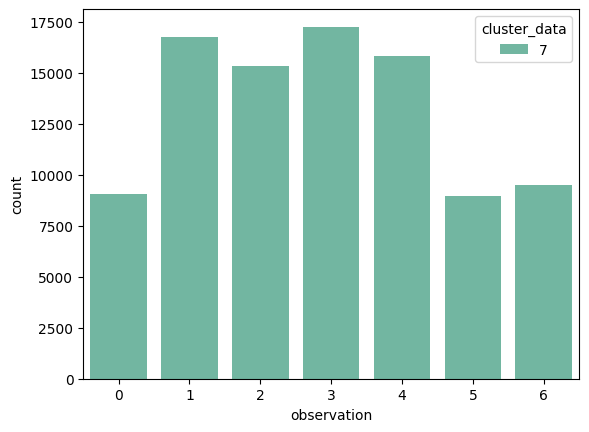

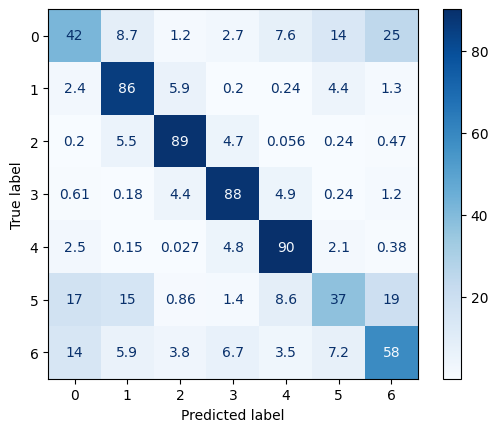

{'average_accuracy': 0.7535976859035505, 'average_f1_macro': np.float64(0.6960345973563399), 'average_f1_micro': np.float64(0.7535976859035505), 'average_auc': np.float64(0.9439279414828702), 'average_acc_kelas_generatif': 0.8819087169485637, 'average_acc_fase_padi': 0.8809645388799278}
{'val_accuracy': 0.7564217212988374, 'val_f1_macro': np.float64(0.6987790906914348), 'val_f1_micro': np.float64(0.7564217212988374), 'val_auc': np.float64(0.9474058448294677), 'val_acc_kelas_generatif': 0.8845357409094674, 'val_acc_fase_padi': 0.8820238278078856, 'val_relative_acc': np.float64(99.3837211698992)}


In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
dict_report={}
for i in np.sort(df.cluster_data.unique()):
    print('=============================================================================')
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_cluster_{i}.png", dpi=300, bbox_inches='tight')
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.7)
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Create an Optuna study and optimize the objective function
    print('Build Best Parameter using Optuna-Hyperparameter Tuning')
    study = optuna.create_study(direction='maximize')  # 'maximize' because we are optimizing accuracy
    study.optimize(lambda trial: objective(trial, X_train, y_train_encoded), n_trials=20)  # Run for 50 trials
    # Print the best parameters and the best score
    print(f"Best Parameters: {study.best_params}")
    print(f"Best Score: {study.best_value}")

    print('Start the modelling')
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded,cluster=i,best_params=study.best_params)
    
    dict_report[i]={'model':model0,
                    'training_metrics':training_metrics0,
                    'validation_metrics':validation_metrics0,
                    'reports':report0,
                    'cm':cm0,
                    'params':study.best_params}
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)
    print('=============================================================================')




In [11]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2.pkl','wb') as file:
    pickle.dump(dict_report,file)